In [ ]:
import math
import pickle

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import torch
import sys
sys.path.append('..')
import os
from env import ROOT_DIR as root

results_dir = os.path.join(root, 'divisivenorm/results/')

# Panels A and B

In [4]:
standardvae_modelname = 'StandardVAE'
eavae_modelname = 'EAVAE_softlaplace'

config = {
    'image_sample_fn': results_dir + 'image_samples40.png',
    f'recf_{standardvae_modelname}_sample_fn': results_dir + f'recf_{standardvae_modelname}_samples.png',
    f'recf_{eavae_modelname}_sample_fn': (results_dir +
                                     f'recf_{eavae_modelname}_samples.png'),
    f'recf_{standardvae_modelname}_active_fn_pre': results_dir + f'recf_{standardvae_modelname}_',
    f'recf_{eavae_modelname}_active_fn_pre': results_dir + f'recf_{eavae_modelname}_',

    'three_violins_plot_fn_pre': results_dir + 'three_violins_',
    'three_violins_std_hists_plot_fn_pre': (results_dir
                                            + 'three_violins_std_hists_'),
    'butterflies_plot_fn_pre': results_dir + 'butterflies_',

    'three_violins_stds_fn': (results_dir + 'three_violins_stds.pkl'),

    'active_recfs_threshold': 0.3,

    'three_violins_percentiles': (25, 75),
    'three_violins_filter_idcs': range(10),
    'three_violins_std_hists_filter_idcs': range(100),

    'bowties_n_bins': 20,

    'img_indices_from': 0,
    'img_indices_to': 64000,

    'standardvae_modelname': standardvae_modelname,
    'eavae_modelname': eavae_modelname,

    'standardvae_ims_fn': f'/{standardvae_modelname}_natural_ims.pt',
    'standardvae_recfs_fn': f'/{standardvae_modelname}_receptive_fields.pt',
    'standardvae_postmns_fn': f'/{standardvae_modelname}_posterior_natural.pt',

    'eavae_ims_fn': f'/{eavae_modelname}_natural_ims.pt',
    'eavae_recfs_fn': f'/{eavae_modelname}_receptive_fields.pt',
    'eavae_postmns_fn': f'/{eavae_modelname}_z_posterior_natural.pt',
    
    'smvae_data_dir': os.path.join(root, '/eval_data/DN/'),

    'vminmax_imgs': 3.0,
    'vminmax_recfs': 6.0,
}

In [3]:
def dprime_e(s1, s2):
    # Calculates the average sd discriminability index between s1 and s2
    return (np.abs(np.mean(s1) - np.mean(s2))
            / (0.5 * (np.std(s1) + np.std(s2))))


def save_samples_png(samps, fn=None, vminmax=1.0):
    # Saves samps to fn
    n_rows = n_cols = math.ceil(math.sqrt(samps.shape[0]))

    if samps.ndim == 2:
        xdim = int(math.sqrt(samps.shape[1]))
        samps = samps.reshape((samps.shape[0], xdim, xdim))

    fig, axs = plt.subplots(n_rows, n_cols, constrained_layout=True,
                            figsize=(10, 10))
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            i_lin = i_row * n_cols + i_col
            ax = axs[i_row, i_col]
            ax.set_xticks([])
            ax.set_yticks([])
            if i_lin < samps.shape[0]:
                img = samps[i_lin, :, :]
                ax.imshow(img, cmap='gray', vmin=-vminmax, vmax=vminmax)

    if fn:
        fig.savefig(fn)


def load_test_images(ims_fn):
    # Load test images (natural, whitened)
    with open(config['smvae_data_dir'] + ims_fn, 'rb') as f:
        if ims_fn.endswith('.pt'):
            test_ims = torch.load(f, map_location='cpu').detach().numpy()
        else:
            test_ims = pickle.load(f).detach().numpy()

    if test_ims.ndim >= 3:
        test_ims = test_ims.reshape((test_ims.shape[0], -1))

    print('loaded test images')
    print(f'  shape: {test_ims.shape}; dtype: {test_ims.dtype}')
    print(f'  pixel mean: {np.mean(test_ims):.5f}; '
          f'std: {np.std(test_ims):.5f}')

    n_samps_sqrt = 5
    save_samples_png(
        test_ims[:n_samps_sqrt * n_samps_sqrt, :],
        config['image_sample_fn'], config['vminmax_imgs'])
    print(f'  saved {n_samps_sqrt}x{n_samps_sqrt} image samples '
          f'to {config["image_sample_fn"]}')

    return test_ims


def load_recfs(recf_fn, model_name, sample_fn):
    # Load receptive fields
    with open(config['smvae_data_dir'] + recf_fn, 'rb') as f:
        if recf_fn.endswith('.pt'):
            recfs = torch.load(f, map_location='cpu')
        else:
            recfs = pickle.load(f)

    if recfs.ndim == 3:
        recfs = recfs.reshape((recfs.shape[0],
                               recfs.shape[1] * recfs.shape[2]))

    print(f'loaded recfields for {model_name}')
    print(f'  shape: {recfs.shape}; dtype: {recfs.dtype}')
    print(f'  mean: {np.mean(recfs):.5f}; '
          f'std: {np.std(recfs):.5f}')

    n_samps_sqrt = 5
    save_samples_png(
        recfs[:n_samps_sqrt * n_samps_sqrt, :],
        sample_fn, config['vminmax_recfs'])
    print(f'  saved {n_samps_sqrt}x{n_samps_sqrt} image samples '
          f'to {sample_fn}')

    return recfs


def load_postmns(postmn_fn, model_name):
    # Load posterior means
    with open(config['smvae_data_dir'] + postmn_fn, 'rb') as f:
        if postmn_fn.endswith('.pt'):
            postmns = torch.load(f, map_location='cpu').detach().numpy()
        else:
            postmns = pickle.load(f).detach().numpy()

    print(f'loaded postmns for {model_name}')
    print(f'  shape: {postmns.shape}; dtype: {postmns.dtype}')
    print(f'  mean: {np.mean(postmns):.5f}; '
          f'std: {np.std(postmns):.5f}')

    return postmns


def active_recfs_postmns(recfs, postmns, threshold=1.0, fn_pre=None,
                         model_name=None):
    active_recfs = recfs[np.std(recfs, axis=1) >= threshold, :]
    active_postmns = postmns[:, np.std(recfs, axis=1) >= threshold]

    inactive_recfs = recfs[np.std(recfs, axis=1) < threshold, :]
    inactive_postmns = postmns[:, np.std(recfs, axis=1) < threshold]

    if fn_pre:
        save_samples_png(
            active_recfs, fn_pre + 'active.png', config['vminmax_recfs'])
        save_samples_png(
            inactive_recfs, fn_pre + 'inactive.png', config['vminmax_recfs'])

    if model_name:
        print(f'found {active_recfs.shape[0]} active and '
              f'{inactive_recfs.shape[0]} inactive z dims '
              f'for {model_name}')

    return active_recfs, active_postmns, inactive_recfs, inactive_postmns


def plot_three_violins_per_filter_pair(
        resps, filter_idcs, resps_type, model_name, format='png'):
    resps = resps[config['img_indices_from']:config['img_indices_to'], :]

    fig, axs = plt.subplots(len(filter_idcs), len(filter_idcs),
                            sharex=True, sharey=True,
                            figsize=[3.2 * len(filter_idcs),
                                     2.4 * len(filter_idcs)],
                            constrained_layout=True)

    for ii, i in enumerate(filter_idcs):
        for jj, j in enumerate(filter_idcs):
            ax = axs[ii, jj]
            if ii == len(filter_idcs) - 1:
                ax.set_xlabel(f'z dimension {j}')
            if jj == 0:
                ax.set_ylabel(f'z dimension {i}')
            if ii != jj:
                resp_i = resps[:, i]
                resp_j = resps[:, j]
                perc_j = np.percentile(resp_j,
                                       config['three_violins_percentiles'])

                ax.violinplot((resp_i[resp_j < perc_j[0]],
                               resp_i[np.logical_and(resp_j >= perc_j[0],
                                                     resp_j < perc_j[1])],
                               resp_i[resp_j >= perc_j[1]]),
                              showmeans=True)
                ax.set_xticks((1, 2, 3))
                ax.set_xticklabels((
                    f'0-{config["three_violins_percentiles"][0]}%',
                    f'{config["three_violins_percentiles"][0]}-'
                    f'{config["three_violins_percentiles"][1]}%',
                    f'{config["three_violins_percentiles"][1]}-100%',
                ))
                ax.axhline(y=0, color='k', lw=0.5)

    fig.suptitle(f'{model_name}, {resps_type} responses, '
                 f'filters {list(filter_idcs)}')

    fig.savefig(config['three_violins_plot_fn_pre']
                + f'{resps_type}_{model_name}.{format}', format=format)

    plt.close()


def plot_three_violin_std_hists(
        resps_standardvae, resps_eavae, filter_idcs,
        resps_type, model_name_standardvae, model_name_eavae,
        format='png', format2='pdf'):
    resps_standardvae = resps_standardvae[config['img_indices_from']:
                                      config['img_indices_to'], :]
    resps_eavae = resps_eavae[config['img_indices_from']:
                                          config['img_indices_to'], :]

    central_stds_standardvae = []
    flanking_stds_standardvae = []
    central_stds_eavae = []
    flanking_stds_eavae = []

    for ii, i in enumerate(filter_idcs):
        for jj, j in enumerate(filter_idcs):
            if ii != jj:
                resp_i_standardvae = resps_standardvae[:, i]
                resp_j_standardvae = resps_standardvae[:, j]
                perc_j_standardvae = np.percentile(
                    resp_j_standardvae, config['three_violins_percentiles'])

                flanking_stds_standardvae.append(np.std(
                    resp_i_standardvae[resp_j_standardvae < perc_j_standardvae[0]]))
                central_stds_standardvae.append(np.std(
                    resp_i_standardvae[np.logical_and(
                        resp_j_standardvae >= perc_j_standardvae[0],
                        resp_j_standardvae < perc_j_standardvae[1])]))
                flanking_stds_standardvae.append(np.std(
                    resp_i_standardvae[resp_j_standardvae >= perc_j_standardvae[1]]))

                resp_i_eavae = resps_eavae[:, i]
                resp_j_eavae = resps_eavae[:, j]
                perc_j_eavae = np.percentile(
                    resp_j_eavae, config['three_violins_percentiles'])

                flanking_stds_eavae.append(np.std(
                    resp_i_eavae[resp_j_eavae
                                       < perc_j_eavae[0]]))
                central_stds_eavae.append(np.std(
                    resp_i_eavae[np.logical_and(
                        resp_j_eavae >= perc_j_eavae[0],
                        resp_j_eavae < perc_j_eavae[1])]))
                flanking_stds_eavae.append(np.std(
                    resp_i_eavae[resp_j_eavae
                                       >= perc_j_eavae[1]]))

    fig, axs = plt.subplots(
        1, 2, sharex=True, sharey=True,
        figsize=[12.8, 4.8], constrained_layout=True)

    ax = axs[0]
    ax.hist(central_stds_standardvae, bins='auto', density=True,
            label=f'{model_name_standardvae}, central')
    ax.hist(flanking_stds_standardvae, bins='auto', density=True,
            label=f'{model_name_standardvae}, flanking')
    ax.set_xlabel('Standard deviation of response')
    ax.set_ylabel('Probability density')
    dprime = dprime_e(np.array(central_stds_standardvae),
                      np.array(flanking_stds_standardvae))
    ax.set_title(f"$d'_e$ = {dprime:.3g}")
    ax.legend()

    ax = axs[1]
    ax.hist(central_stds_eavae, bins='auto', density=True,
            label=f'{model_name_eavae}, central')
    ax.hist(flanking_stds_eavae, bins='auto', density=True,
            label=f'{model_name_eavae}, flanking')
    ax.set_xlabel('Standard deviation of response')
    ax.set_ylabel('Probability density')
    dprime = dprime_e(np.array(central_stds_eavae),
                      np.array(flanking_stds_eavae))
    ax.set_title(f"$d'_e$ = {dprime:.3g}")
    ax.legend()

    fig.suptitle(f'{resps_type.capitalize()} responses, '
                 f'{len(filter_idcs)} filters')

    fig.savefig(config['three_violins_std_hists_plot_fn_pre']
                + f'{resps_type}_{len(filter_idcs)}filters.{format}',
                format=format)
    fig.savefig(config['three_violins_std_hists_plot_fn_pre']
                + f'{resps_type}_{len(filter_idcs)}filters.{format2}',
                format=format2)

    plt.close()

    return (central_stds_standardvae, flanking_stds_standardvae,
            central_stds_eavae, flanking_stds_eavae)


def plot_bowties(
        resps, filter_idcs, resps_type, model_name, n_bins,
        format='png', format2='pdf'):
    resps = resps[config['img_indices_from']:config['img_indices_to'], :]

    bins_sum = np.zeros((n_bins, n_bins))

    fig, axs = plt.subplots(len(filter_idcs), len(filter_idcs),
                            layout='compressed',
                            figsize=[1.5 * len(filter_idcs),
                                     1.2 * len(filter_idcs)])

    for ii, i in enumerate(filter_idcs):
        for jj, j in enumerate(filter_idcs):
            ax = axs[ii, jj]
            if ii == len(filter_idcs) - 1:
                ax.set_xlabel(f'z dimension {j}')
            if jj == 0:
                ax.set_ylabel(f'z dimension {i}')
            if ii == jj:
                max_resp = np.max(np.abs(resps[:, i])) * 1.001
                ax.set_xlim(-max_resp, max_resp)
                ax.set_ylim(-max_resp, max_resp)
                ax.set_xticks((-max_resp, max_resp))
                ax.set_yticks((-max_resp, max_resp))
                ax.set_aspect('equal')
            else:
                max_resp = np.max(np.abs(resps[:, [i, j]])) * 1.001
                idx_i = np.floor((resps[:, i] + max_resp)
                                 / (2 * max_resp) * n_bins).astype(np.int64)
                idx_j = np.floor((resps[:, j] + max_resp)
                                 / (2 * max_resp) * n_bins).astype(np.int64)
                idx_ij = n_bins * idx_i + idx_j

                bins = np.zeros((n_bins, n_bins))
                np.add.at(np.ravel(bins), idx_ij, 1)
                bins_sum += bins

                for j in range(n_bins):
                    if np.max(bins[:, j]) > 0:
                        bins[:, j] /= np.max(bins[:, j])

                ax.imshow(bins, cmap='gray', vmin=0, vmax=1)

                ax.set_xticks((-0.5, n_bins - 0.5))
                ax.set_xticklabels((f'{-max_resp:.3g}', f'{max_resp:.3g}'))
                ax.set_yticks((-0.5, n_bins - 0.5))
                ax.set_yticklabels((f'{-max_resp:.3g}', f'{max_resp:.3g}'))
                ax.set_aspect('equal')

    fig.suptitle(f'{model_name}, {resps_type} responses, '
                 f'filters {list(filter_idcs)}')

    fig.savefig(config['butterflies_plot_fn_pre']
                + f'{resps_type}_{model_name}.{format}', format=format)
    fig.savefig(config['butterflies_plot_fn_pre']
                + f'{resps_type}_{model_name}.{format2}', format=format2)

    plt.close

    for j in range(n_bins):
        if np.max(bins_sum[:, j]) > 0:
            bins_sum[:, j] /= np.max(bins_sum[:, j])

    fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(bins_sum, cmap='gray', vmin=0, vmax=1)
    fig.suptitle(f'{model_name}, {resps_type} responses, '
                 f'filters {list(filter_idcs)}')
    fig.savefig(config['butterflies_plot_fn_pre']
                + f'{resps_type}_{model_name}_summed.{format}', format=format)
    fig.savefig(config['butterflies_plot_fn_pre']
                + f'{resps_type}_{model_name}_summed.{format2}',
                format=format2)
    plt.close

loaded test images
  shape: (64000, 1600); dtype: float32
  pixel mean: -0.00000; std: 0.88600
  saved 5x5 image samples to /app/divisivenorm/results/image_samples40.png
loaded recfields for StandardVAE
  shape: (1800, 1600); dtype: float32
  mean: -0.00085; std: 1.46185


  saved 5x5 image samples to /app/divisivenorm/results/recf_StandardVAE_samples.png
loaded postmns for StandardVAE
  shape: (64000, 1800); dtype: float32
  mean: -0.00004; std: 1.12829
found 1256 active and 544 inactive z dims for StandardVAE
calculated linear responses for StandardVAE
  shape: (64000, 1256); dtype: float32
  mean: 0.00000; std: 64.47011


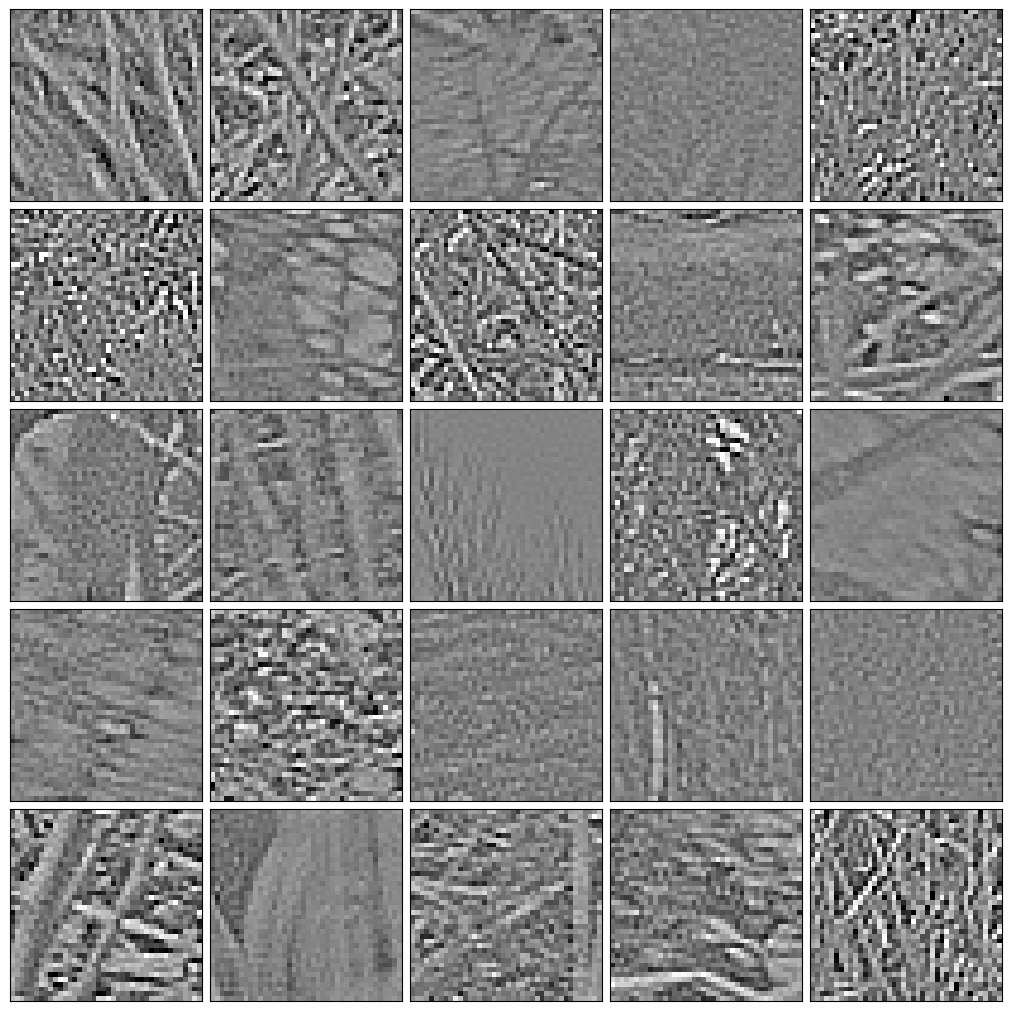

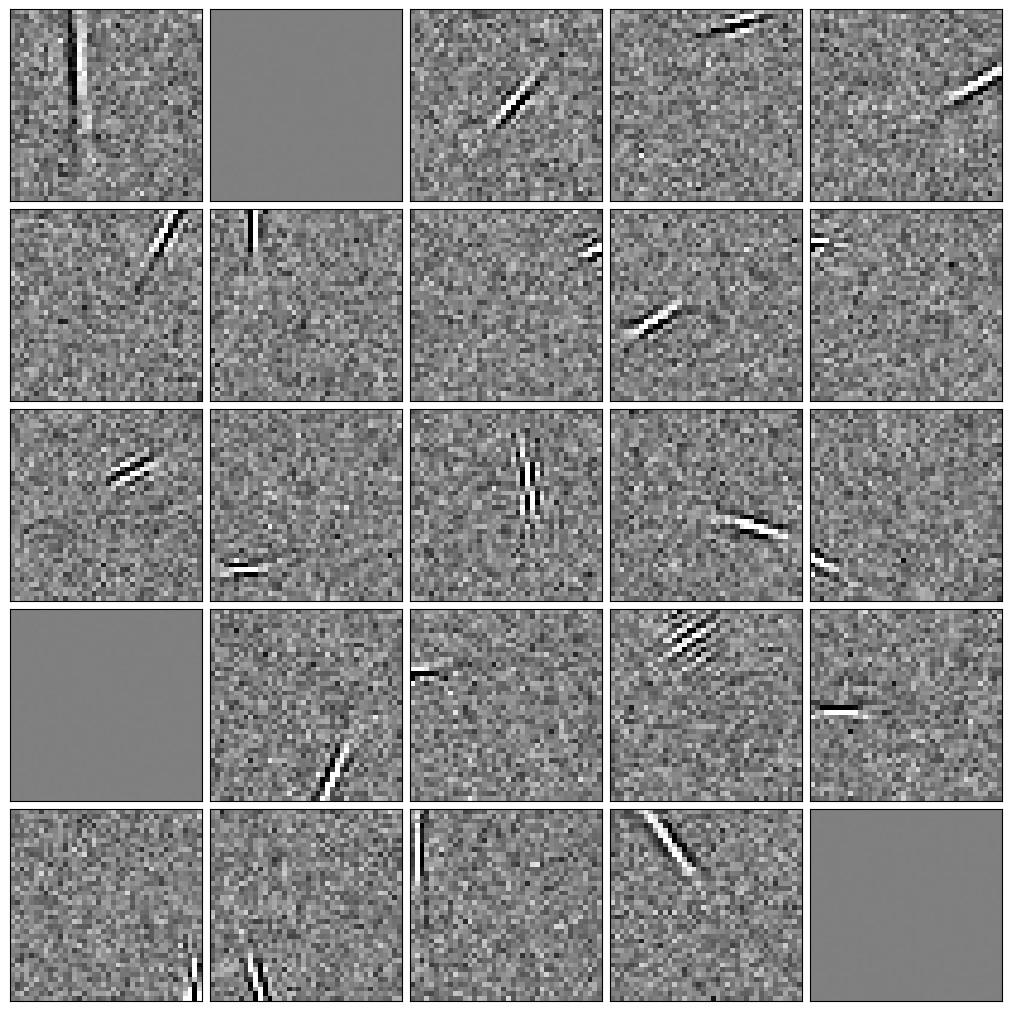

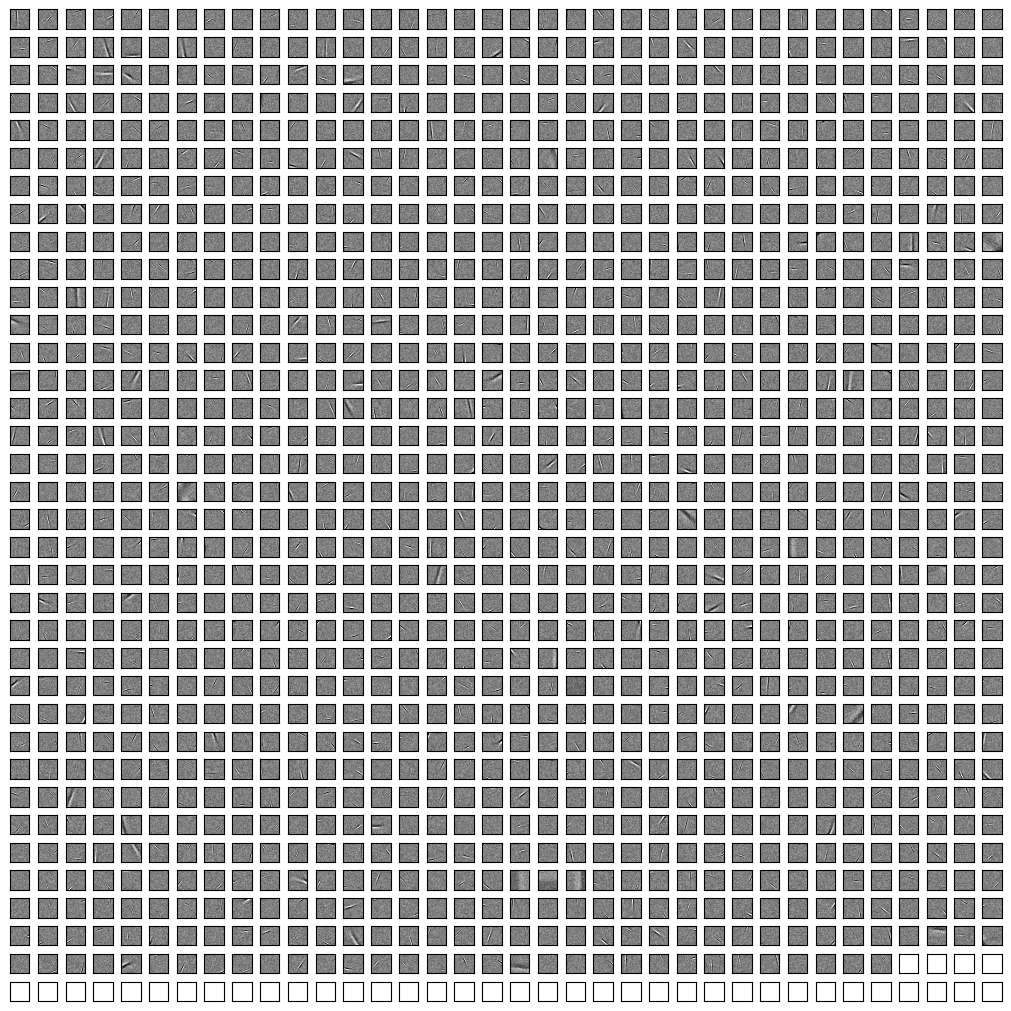

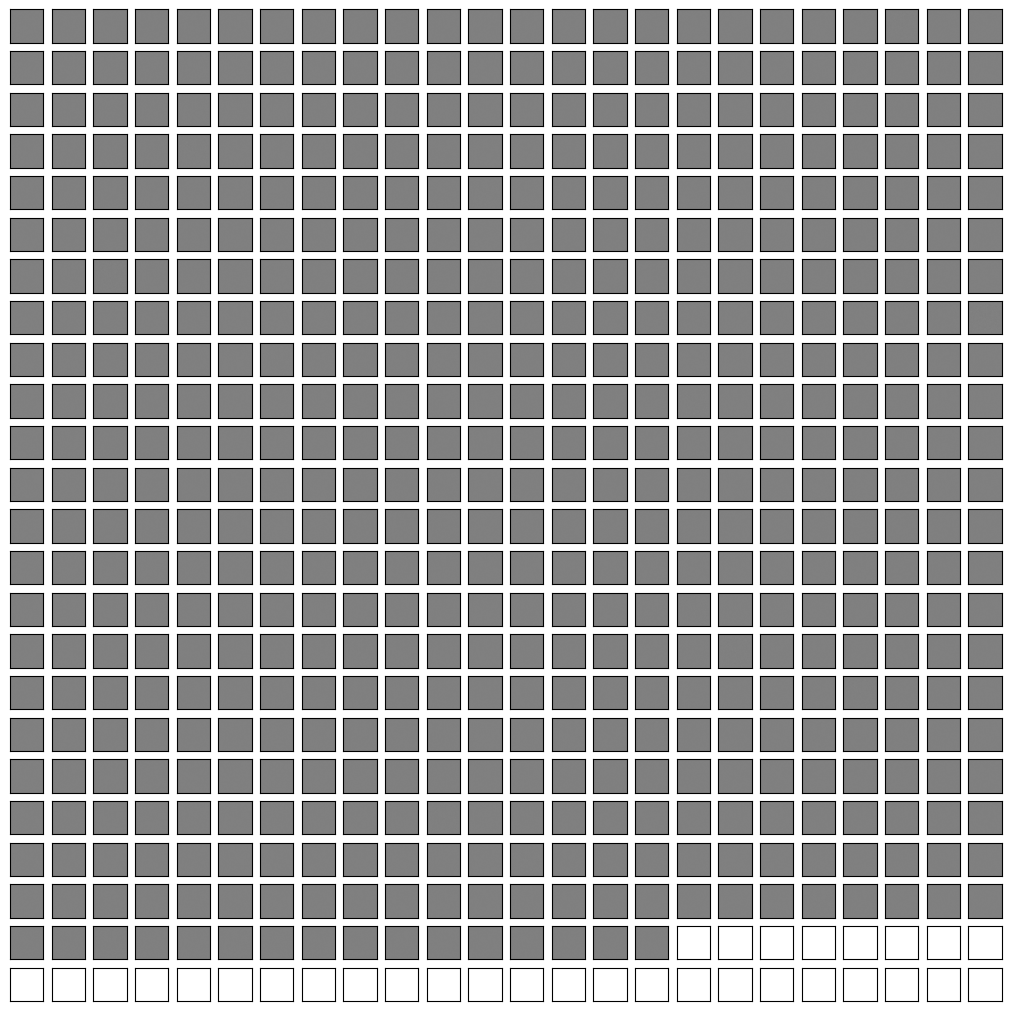

In [4]:
# standardvae
model_name_standardvae = config['standardvae_modelname']

if 'standardvae_ims_fn' in config:
    test_ims_standardvae = load_test_images(
        f'{model_name_standardvae}{config["standardvae_ims_fn"]}')
else:
    test_ims_standardvae = load_test_images(
        f'{model_name_standardvae}_input_ims.pkl')
if 'standardvae_recfs_fn' in config:
    recfs_standardvae = load_recfs(
        f'{model_name_standardvae}{config["standardvae_recfs_fn"]}',
        model_name_standardvae,
        config[f'recf_{model_name_standardvae}_sample_fn'])
else:
    recfs_standardvae = load_recfs(
        f'{model_name_standardvae}_receptive.pkl', model_name_standardvae,
        config[f'recf_{model_name_standardvae}_sample_fn'])
if 'standardvae_postmns_fn' in config:
    postmns_standardvae = load_postmns(
        f'{model_name_standardvae}{config["standardvae_postmns_fn"]}',
        model_name_standardvae)
else:
    postmns_standardvae = load_postmns(
        f'{model_name_standardvae}_posteriors_cpu.pkl',
        model_name_standardvae)

# harmonize data following the instructions from Domo
if test_ims_standardvae.shape[0] != postmns_standardvae.shape[0]:
    print('the number of images and posteriors differ; '
          'using the smaller number everywhere')
    n_ims = min(test_ims_standardvae.shape[0], postmns_standardvae.shape[0])
    test_ims_standardvae = test_ims_standardvae[:n_ims, :]
    postmns_standardvae = postmns_standardvae[:n_ims, :]
if recfs_standardvae.shape[0] != postmns_standardvae.shape[1]:
    print('the number of z dims in receptive fields and posteriors '
          'differ; using the smaller number everywhere')
    n_zdims = min(recfs_standardvae.shape[0], postmns_standardvae.shape[1])
    recfs_standardvae = recfs_standardvae[:n_zdims, :]
    postmns_standardvae = postmns_standardvae[:, :n_zdims]

active_recfs_standardvae, active_postmns_standardvae, \
    inactive_recfs_standardvae, inactive_postmns_standardvae = \
    active_recfs_postmns(
        recfs_standardvae, postmns_standardvae,
        config['active_recfs_threshold'],
        config[f'recf_{model_name_standardvae}_active_fn_pre'],
        model_name_standardvae)

linear_responses_standardvae = np.matmul(
    test_ims_standardvae, active_recfs_standardvae.T)
print(f'calculated linear responses for {model_name_standardvae}')
print(f'  shape: {linear_responses_standardvae.shape}; '
      f'dtype: {linear_responses_standardvae.dtype}')
print(f'  mean: {np.mean(linear_responses_standardvae):.5f}; '
      f'std: {np.std(linear_responses_standardvae):.5f}')

In [5]:
plot_three_violins_per_filter_pair(
    linear_responses_standardvae, config['three_violins_filter_idcs'],
    'linear', config['standardvae_modelname'], format='png')
plot_three_violins_per_filter_pair(
    linear_responses_standardvae, config['three_violins_filter_idcs'],
    'linear', config['standardvae_modelname'], format='pdf')

plot_three_violins_per_filter_pair(
    active_postmns_standardvae, config['three_violins_filter_idcs'],
    'model', config['standardvae_modelname'], format='png')
plot_three_violins_per_filter_pair(
    active_postmns_standardvae, config['three_violins_filter_idcs'],
    'model', config['standardvae_modelname'], format='pdf')

loaded test images
  shape: (64000, 1600); dtype: float32
  pixel mean: -0.00000; std: 0.88600
  saved 5x5 image samples to /app/divisivenorm/results/image_samples40.png
loaded recfields for EAVAE_softlaplace
  shape: (1800, 1600); dtype: float32
  mean: 0.00023; std: 1.27279
  saved 5x5 image samples to /app/divisivenorm/results/recf_EAVAE_softlaplace_samples.png
loaded postmns for EAVAE_softlaplace
  shape: (64000, 1799); dtype: float32
  mean: 0.00156; std: 0.95245
the number of z dims in receptive fields and posteriors differ; using the smaller number everywhere
found 1256 active and 543 inactive z dims for EAVAE_softlaplace
calculated linear responses for EAVAE_softlaplace
  shape: (64000, 1256); dtype: float32
  mean: 0.00000; std: 56.21669


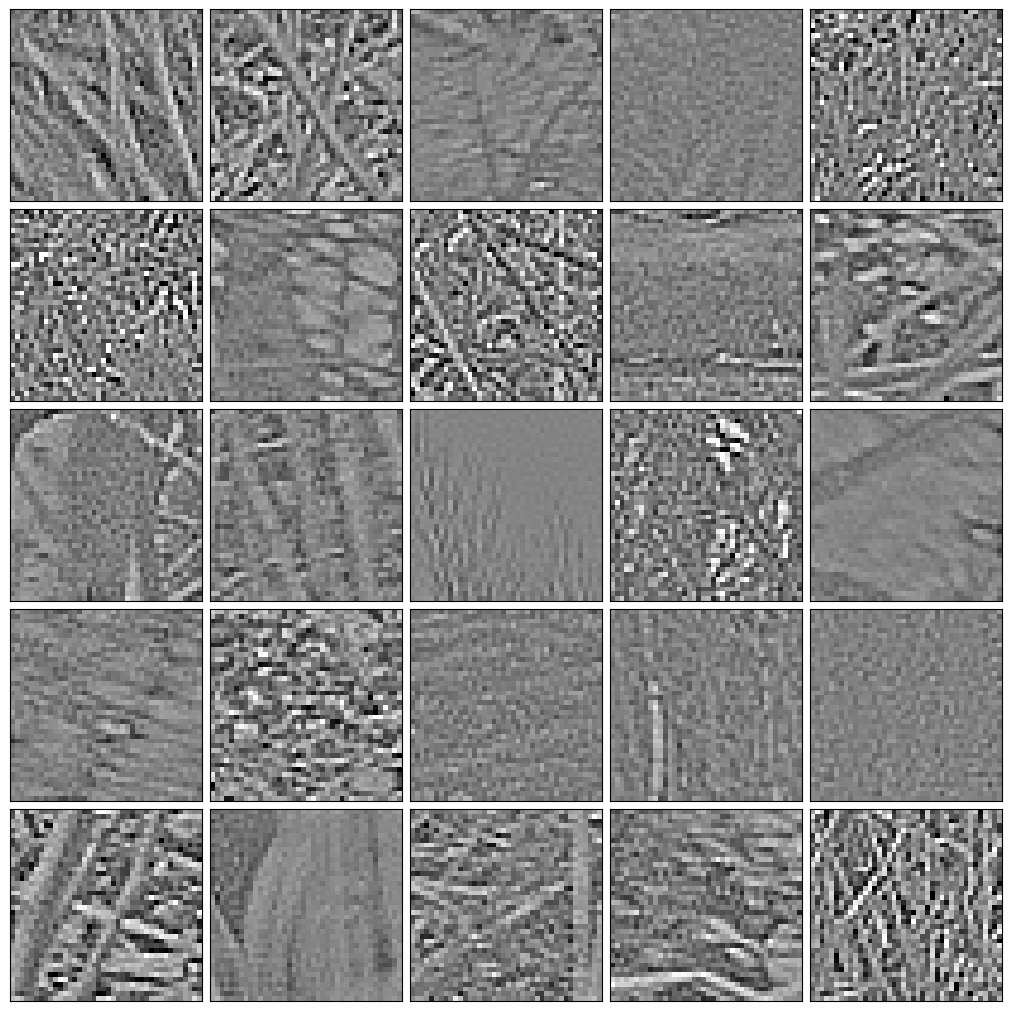

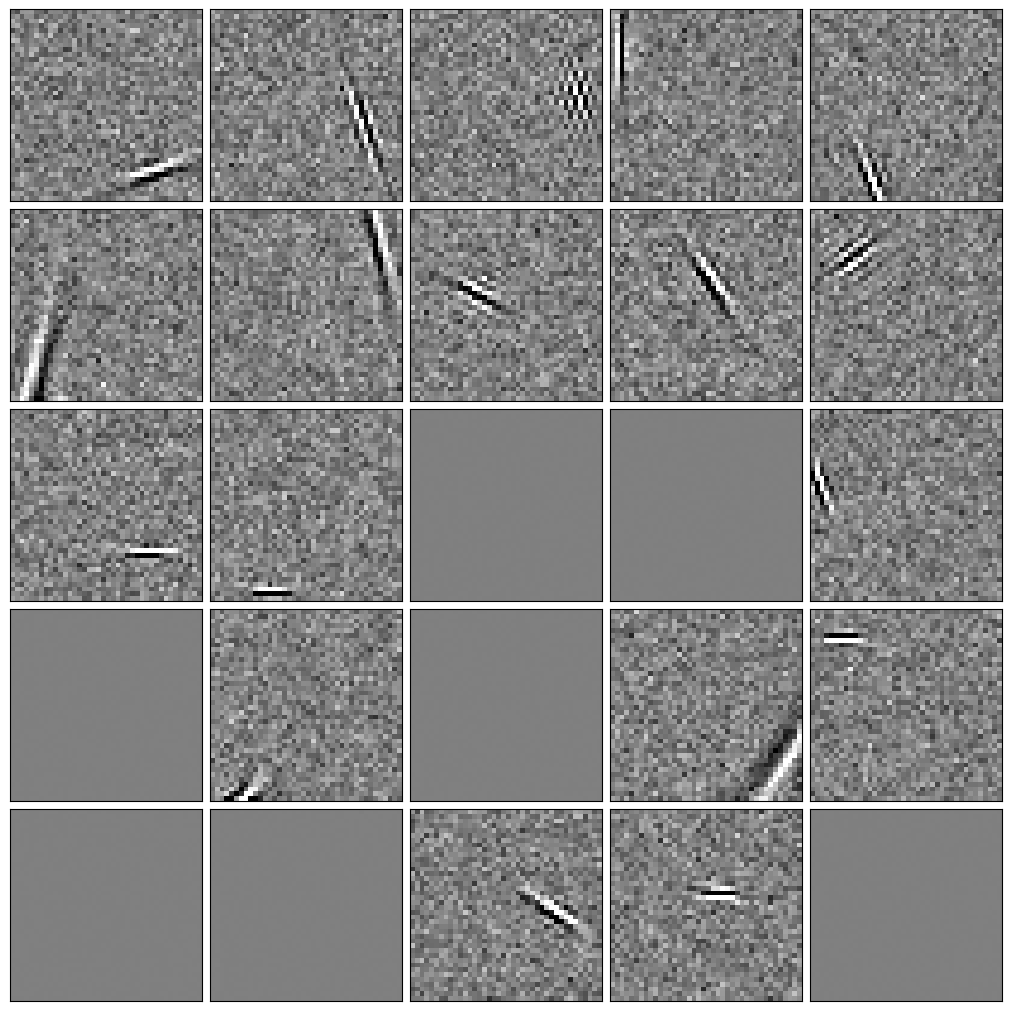

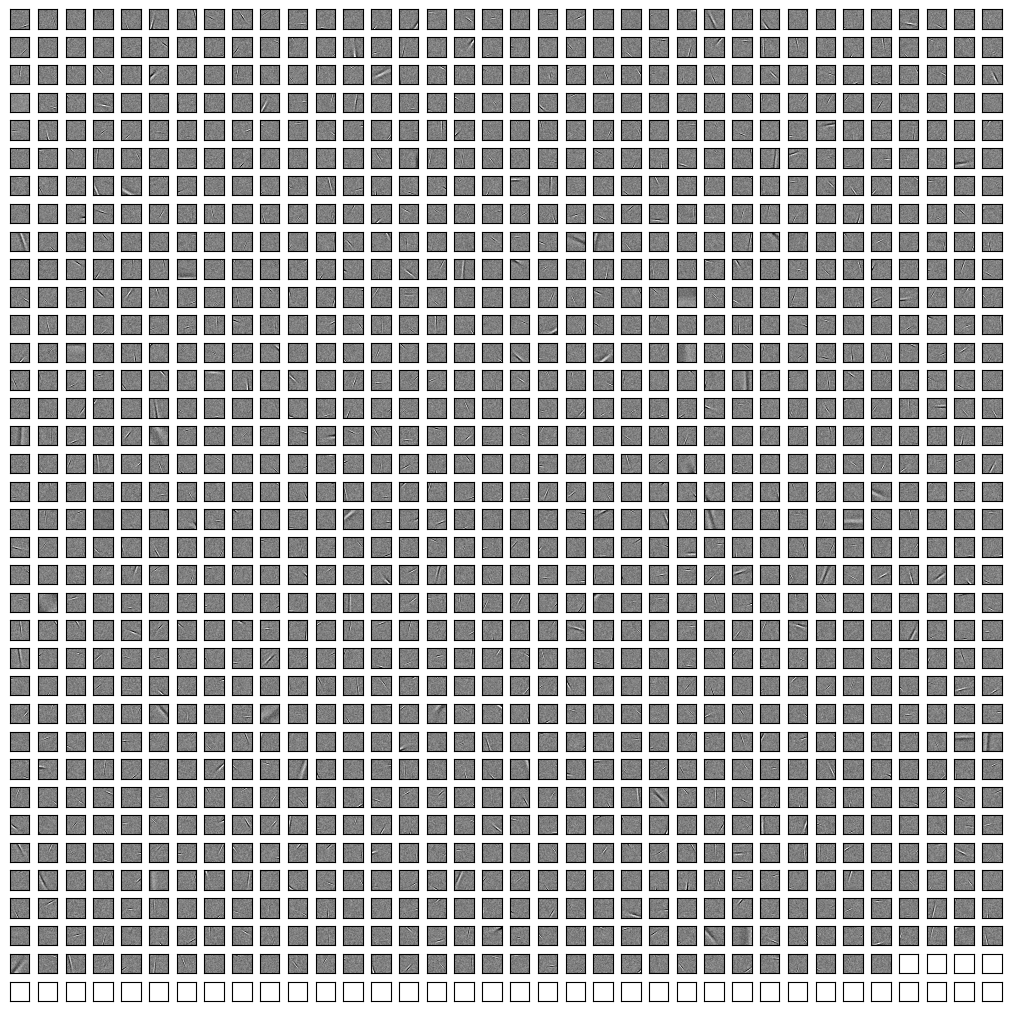

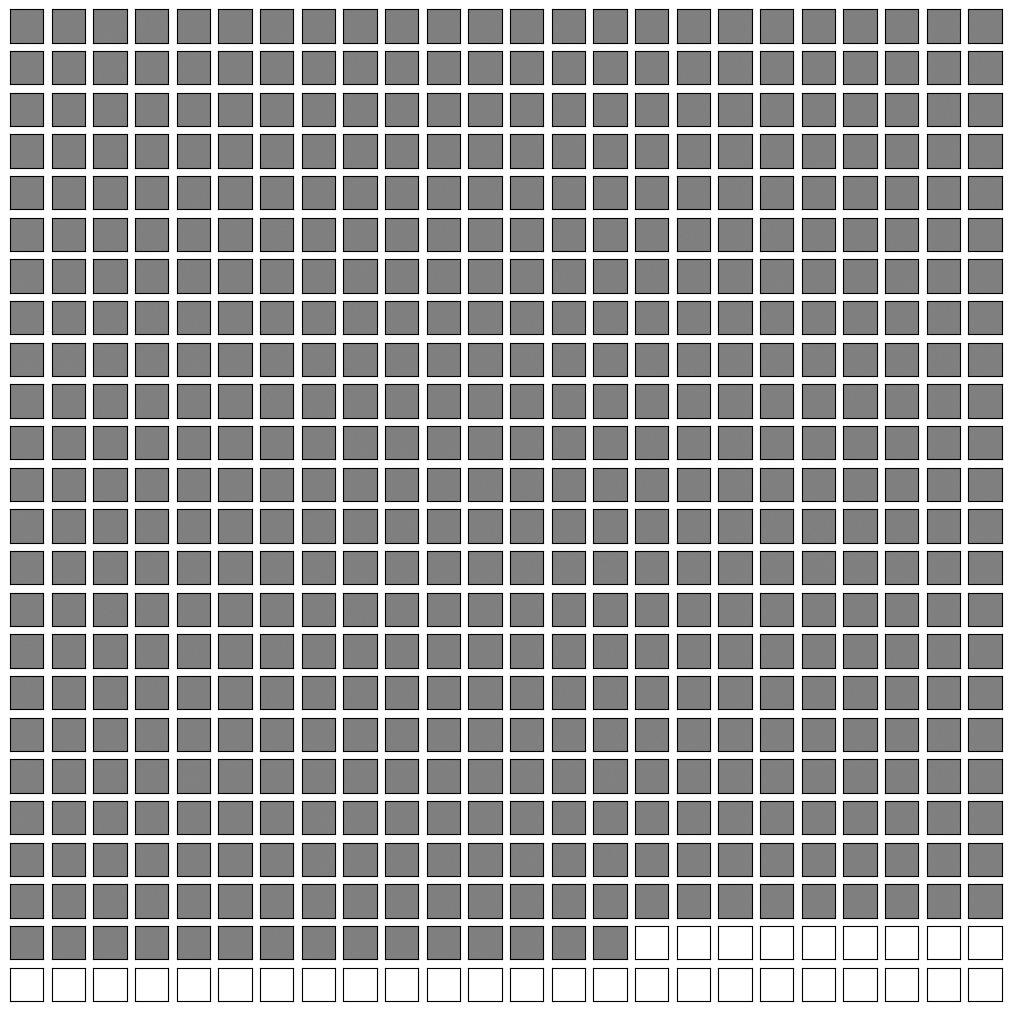

In [6]:
# eavae
model_name_eavae = config['eavae_modelname']
if 'eavae_ims_fn' in config:
    test_ims_eavae = load_test_images(
        f'{model_name_eavae}{config["eavae_ims_fn"]}')
else:
    test_ims_eavae = load_test_images(
        f'{model_name_eavae}_input_ims.pkl')
if 'eavae_recfs_fn' in config:
    recfs_eavae = load_recfs(
        f'{model_name_eavae}{config["eavae_recfs_fn"]}',
        model_name_eavae,
        config[f'recf_{model_name_eavae}_sample_fn'])
else:
    recfs_eavae = load_recfs(
        f'{model_name_eavae}_receptive.pkl', model_name_eavae,
        config[f'recf_{model_name_eavae}_sample_fn'])
if 'eavae_postmns_fn' in config:
    postmns_eavae = load_postmns(
        f'{model_name_eavae}{config["eavae_postmns_fn"]}',
        model_name_eavae)
else:
    postmns_eavae = load_postmns(
        f'{model_name_eavae}_posteriors_cpu.pkl',
        model_name_eavae)

# harmonize data following the instructions from Domo
if test_ims_eavae.shape[0] != postmns_eavae.shape[0]:
    print('the number of images and posteriors differ; '
          'using the smaller number everywhere')
    n_ims = min(test_ims_eavae.shape[0],
                postmns_eavae.shape[0])
    test_ims_eavae = test_ims_eavae[:n_ims, :]
    postmns_eavae = postmns_eavae[:n_ims, :]
if recfs_eavae.shape[0] != postmns_eavae.shape[1]:
    print('the number of z dims in receptive fields and posteriors '
          'differ; using the smaller number everywhere')
    n_zdims = min(recfs_eavae.shape[0], postmns_eavae.shape[1])
    recfs_eavae = recfs_eavae[:n_zdims, :]
    postmns_eavae = postmns_eavae[:, :n_zdims]

active_recfs_eavae, active_postmns_eavae, \
    inactive_recfs_eavae, inactive_postmns_eavae = \
    active_recfs_postmns(
        recfs_eavae, postmns_eavae,
        config['active_recfs_threshold'],
        config[f'recf_{model_name_eavae}_active_fn_pre'],
        model_name_eavae)

linear_responses_eavae = np.matmul(
    test_ims_eavae, active_recfs_eavae.T)
print(f'calculated linear responses for {model_name_eavae}')
print(f'  shape: {linear_responses_eavae.shape}; '
      f'dtype: {linear_responses_eavae.dtype}')
print(f'  mean: {np.mean(linear_responses_eavae):.5f}; '
      f'std: {np.std(linear_responses_eavae):.5f}')

In [7]:
plot_three_violins_per_filter_pair(
    linear_responses_eavae, config['three_violins_filter_idcs'],
    'linear', config['eavae_modelname'], format='png')
plot_three_violins_per_filter_pair(
    linear_responses_eavae, config['three_violins_filter_idcs'],
    'linear', config['eavae_modelname'], format='pdf')

plot_three_violins_per_filter_pair(
    active_postmns_eavae, config['three_violins_filter_idcs'],
    'model', config['eavae_modelname'], format='png')
plot_three_violins_per_filter_pair(
    active_postmns_eavae, config['three_violins_filter_idcs'],
    'model', config['eavae_modelname'], format='pdf')

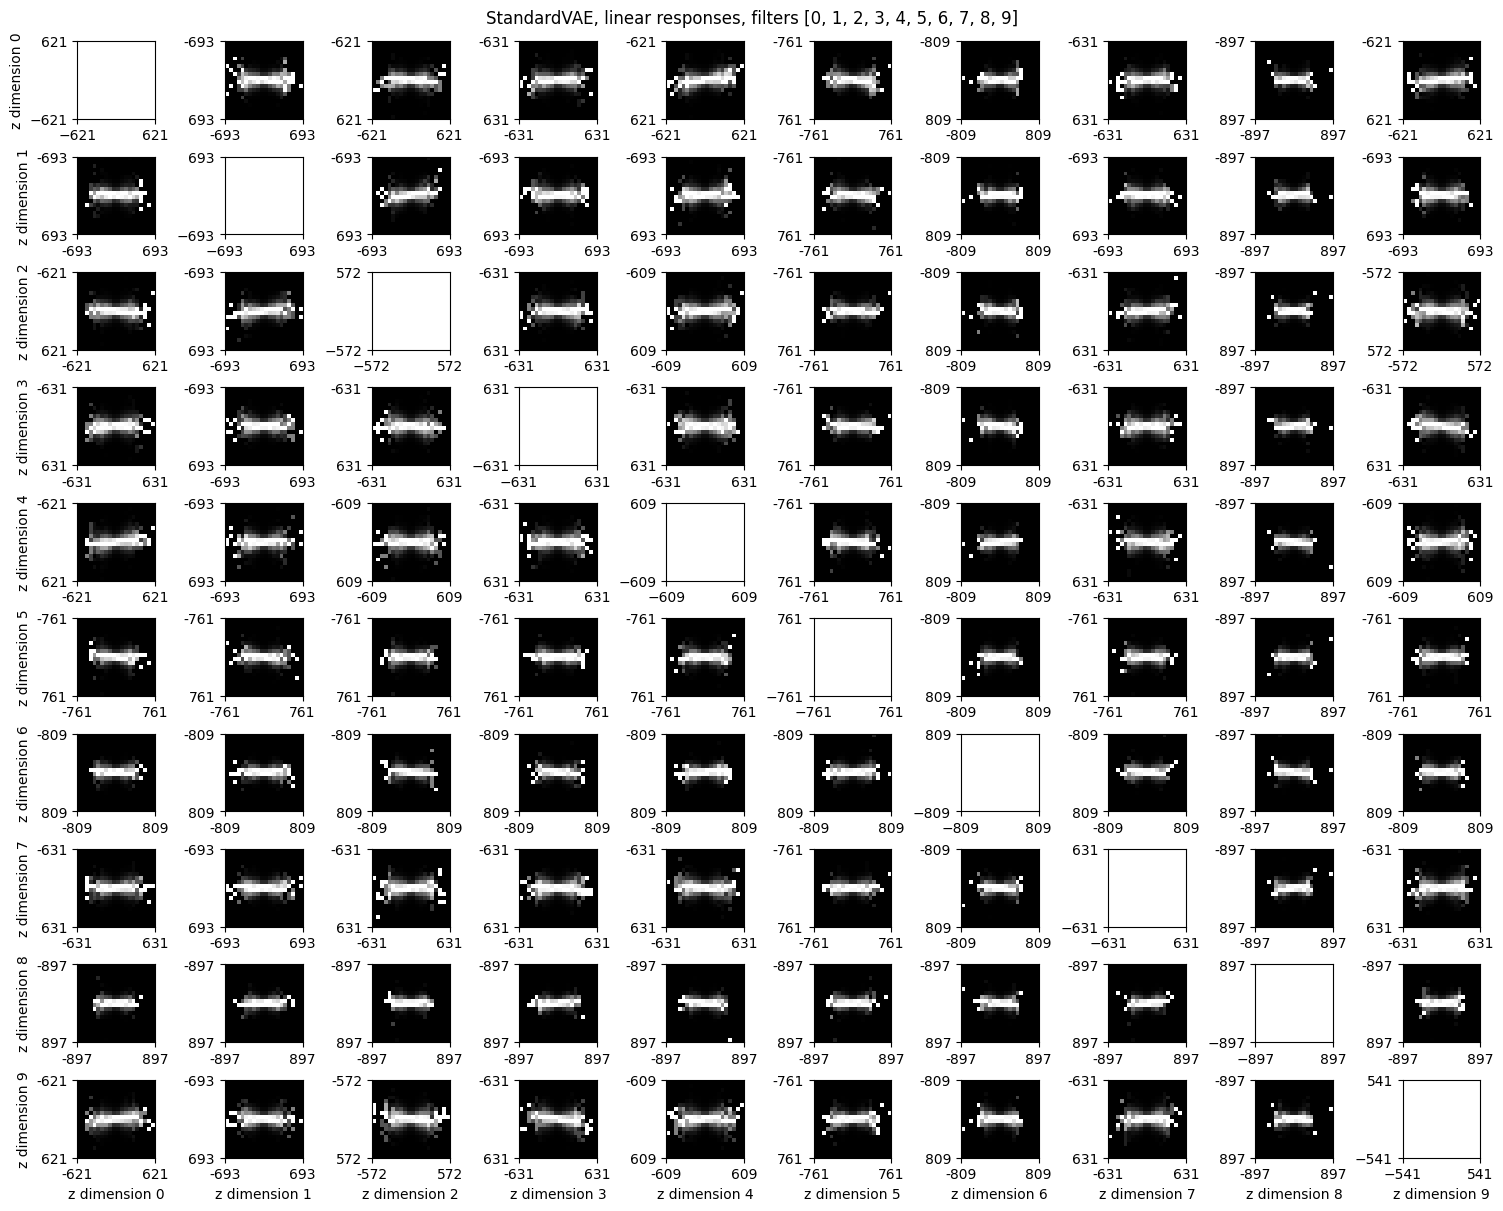

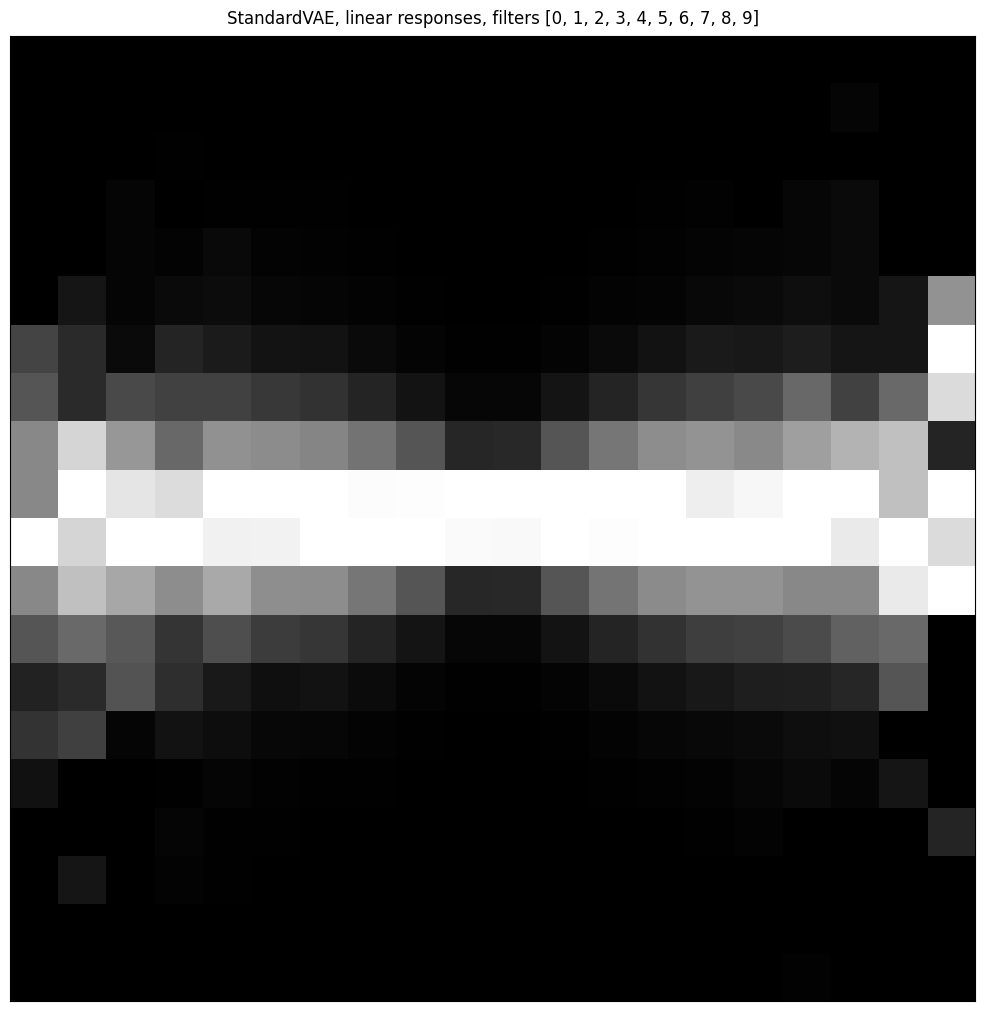

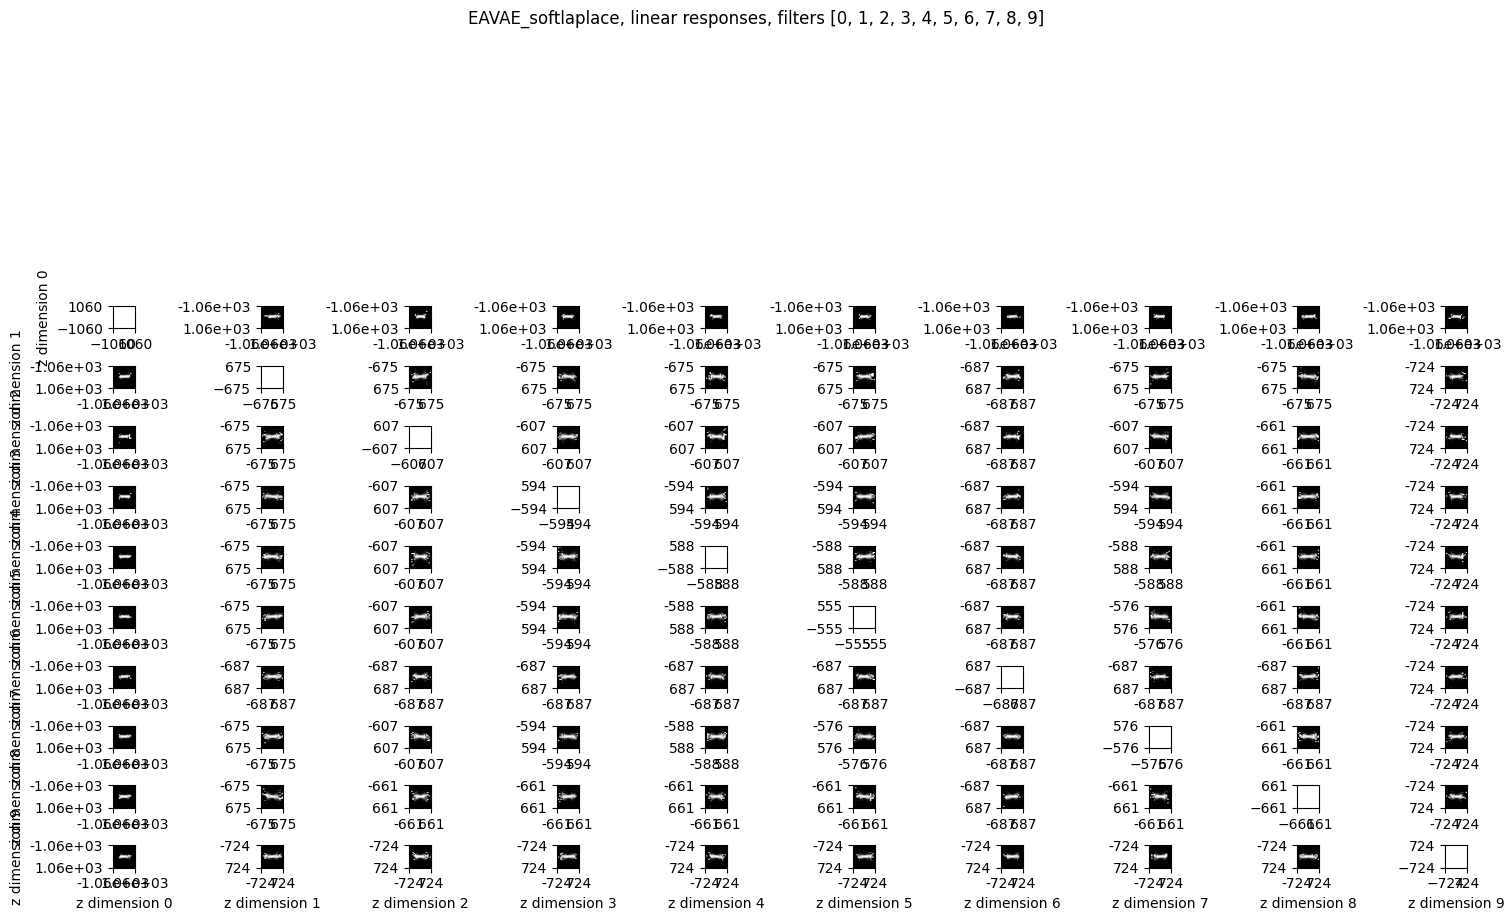

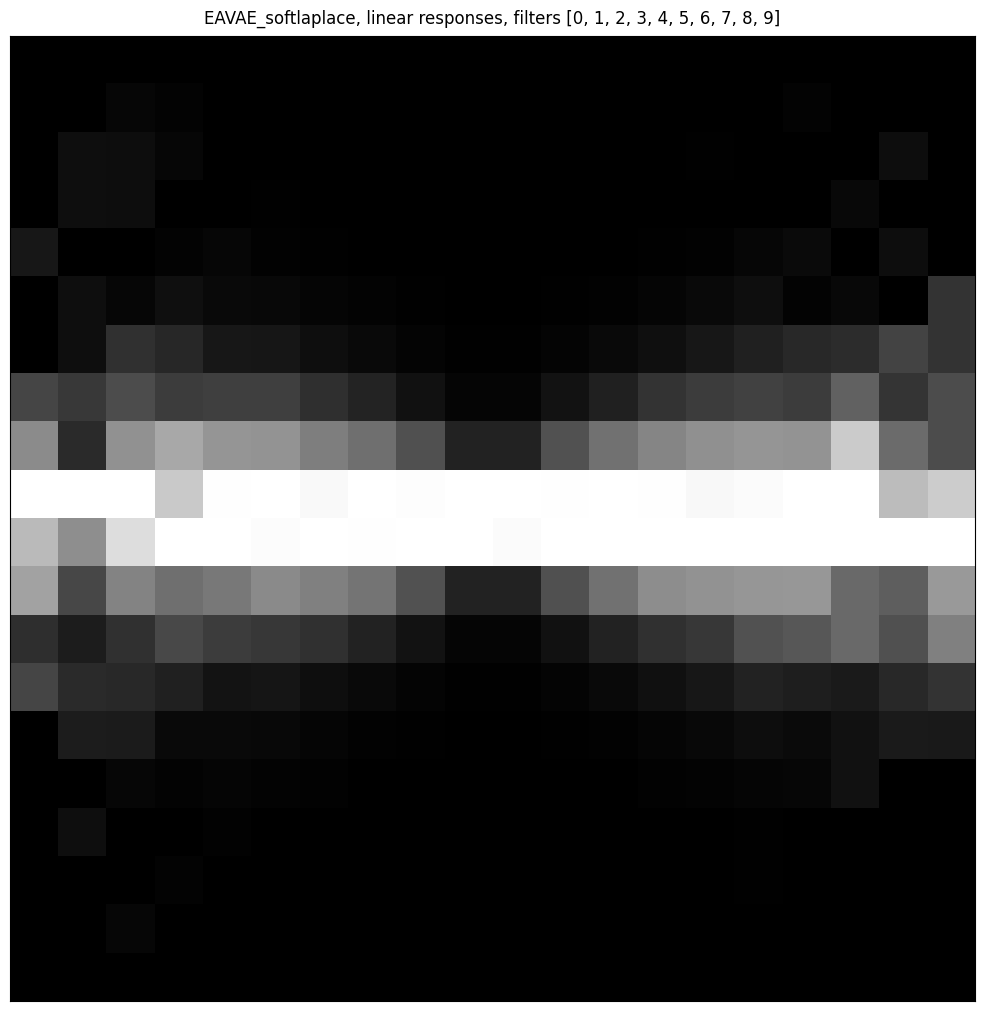

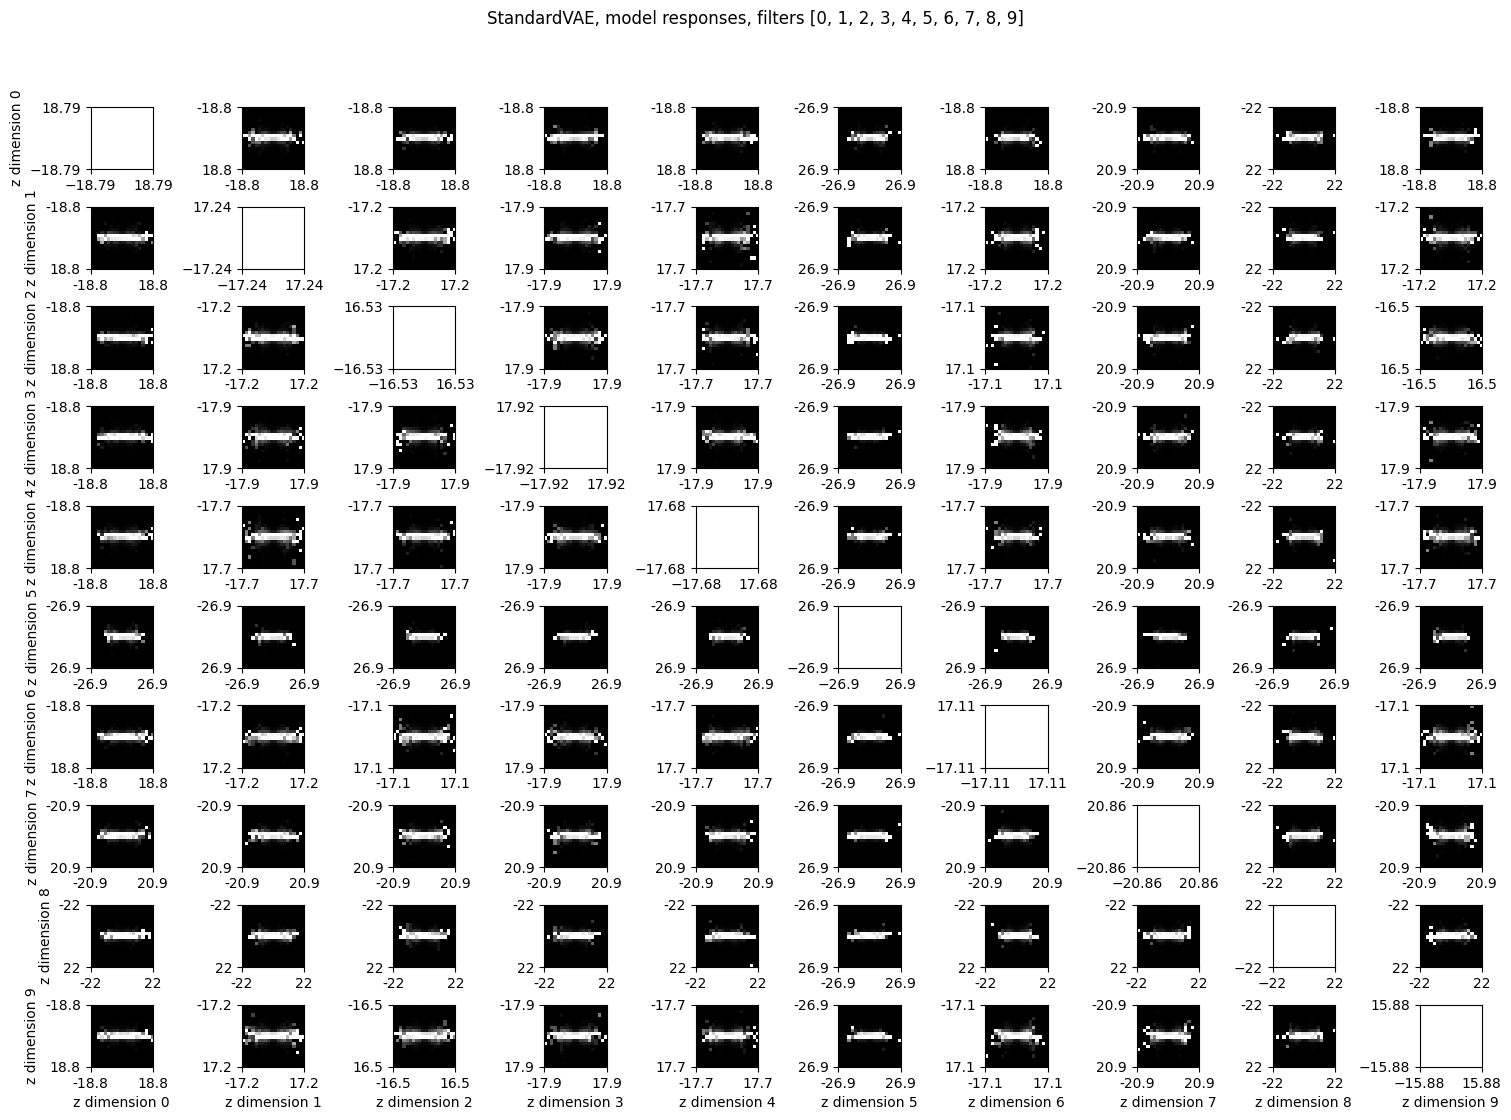

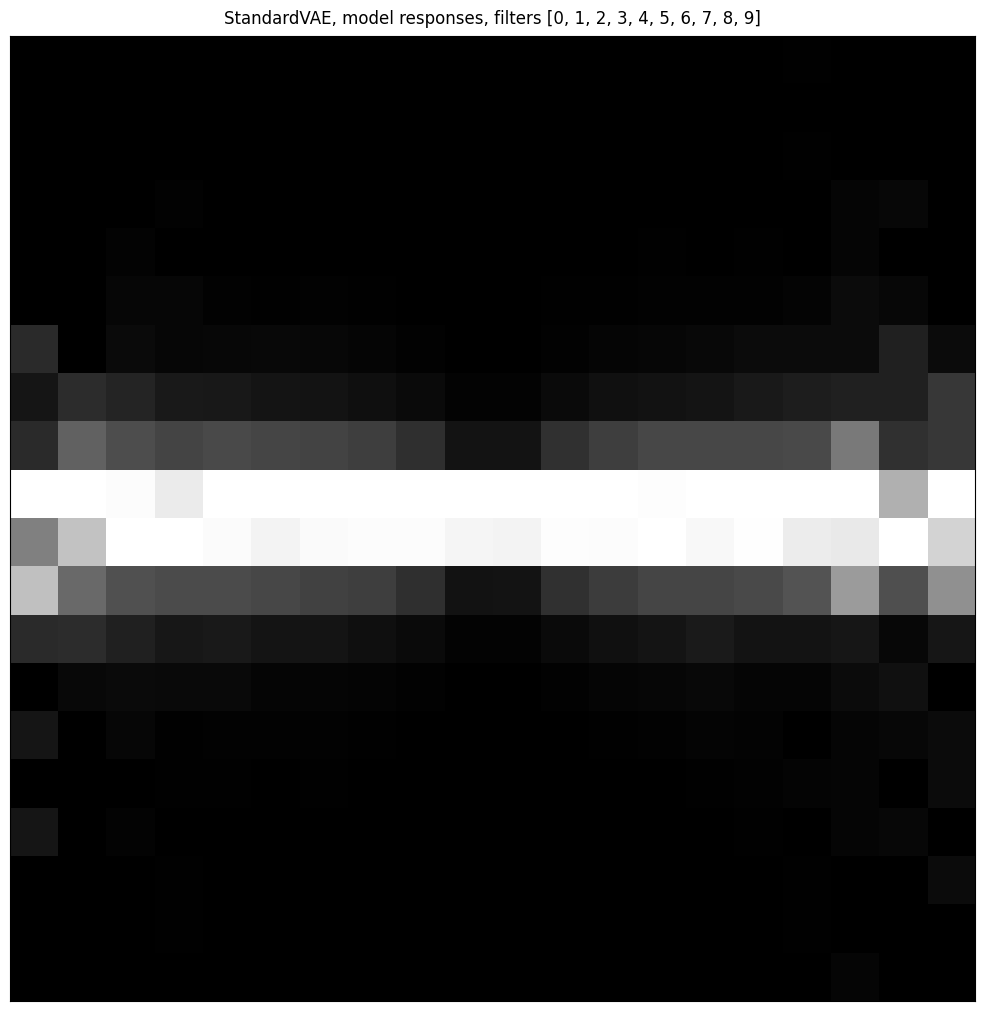

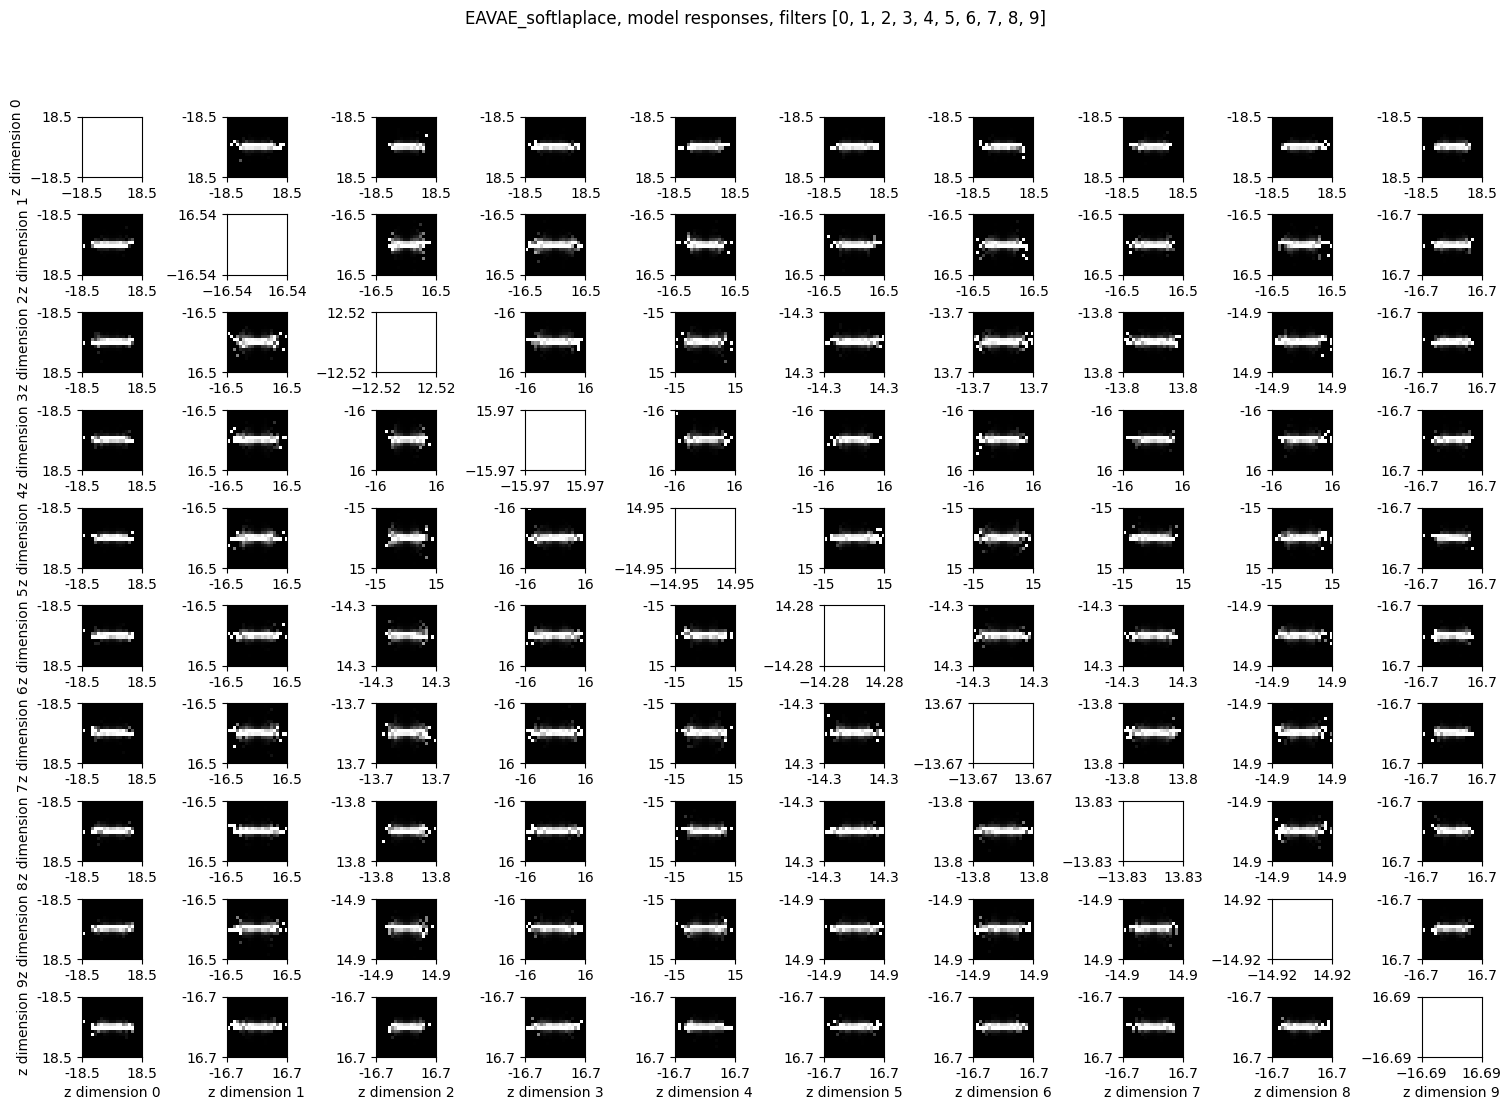

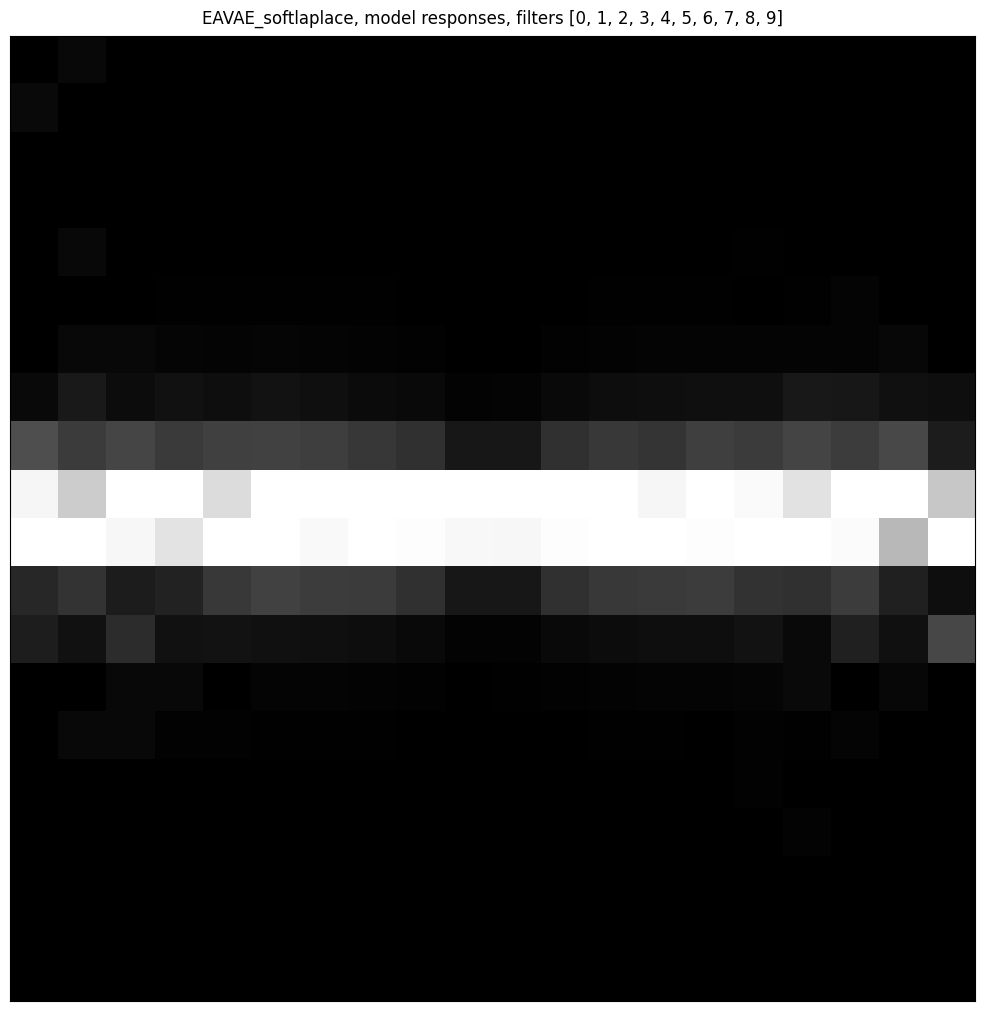

In [8]:
plot_bowties(linear_responses_standardvae, range(10),
             'linear', config['standardvae_modelname'],
             config['bowties_n_bins'], 'png', 'pdf')
plot_bowties(linear_responses_eavae, range(10),
             'linear', config['eavae_modelname'],
             config['bowties_n_bins'], 'png', 'pdf')
plot_bowties(active_postmns_standardvae, range(10),
             'model', config['standardvae_modelname'],
             config['bowties_n_bins'], 'png', 'pdf')
plot_bowties(active_postmns_eavae, range(10),
             'model', config['eavae_modelname'],
             config['bowties_n_bins'], 'png', 'pdf')

In [9]:
three_violins_stds = pickle.load(open(results_dir + f'three_violins_stds_{standardvae_modelname}_{eavae_modelname}.pkl', 'rb'))

In [10]:
def plot_three_violin_std_hists(
        resps_standardvae, resps_eavae, filter_idcs,
        resps_type, model_name_standardvae, model_name_eavae, colors, 
        format='png', format2='pdf', 
        central_stds_standardvae=None, flanking_stds_standardvae=None,
        central_stds_eavae=None, flanking_stds_eavae=None, histBins='auto'):
    resps_standardvae = resps_standardvae[config['img_indices_from']:
                                      config['img_indices_to'], :]
    resps_eavae = resps_eavae[config['img_indices_from']:
                                          config['img_indices_to'], :]

    sns.set_theme(style = "ticks") 
    
    if central_stds_standardvae == None:
        central_stds_standardvae = []
        flanking_stds_standardvae = []
        central_stds_eavae = []
        flanking_stds_eavae = []
    
        for ii, i in enumerate(filter_idcs):
            for jj, j in enumerate(filter_idcs):
                if ii != jj:
                    resp_i_standardvae = resps_standardvae[:, i]
                    resp_j_standardvae = resps_standardvae[:, j]
                    perc_j_standardvae = np.percentile(
                        resp_j_standardvae, config['three_violins_percentiles'])
    
                    flanking_stds_standardvae.append(np.std(
                        resp_i_standardvae[resp_j_standardvae < perc_j_standardvae[0]]))
                    central_stds_standardvae.append(np.std(
                        resp_i_standardvae[np.logical_and(
                            resp_j_standardvae >= perc_j_standardvae[0],
                            resp_j_standardvae < perc_j_standardvae[1])]))
                    flanking_stds_standardvae.append(np.std(
                        resp_i_standardvae[resp_j_standardvae >= perc_j_standardvae[1]]))
    
                    resp_i_eavae = resps_eavae[:, i]
                    resp_j_eavae = resps_eavae[:, j]
                    perc_j_eavae = np.percentile(
                        resp_j_eavae, config['three_violins_percentiles'])
    
                    flanking_stds_eavae.append(np.std(
                        resp_i_eavae[resp_j_eavae
                                           < perc_j_eavae[0]]))
                    central_stds_eavae.append(np.std(
                        resp_i_eavae[np.logical_and(
                            resp_j_eavae >= perc_j_eavae[0],
                            resp_j_eavae < perc_j_eavae[1])]))
                    flanking_stds_eavae.append(np.std(
                        resp_i_eavae[resp_j_eavae
                                           >= perc_j_eavae[1]]))

    fig, axs = plt.subplots(
        1, 2, sharex=True, sharey=True,
        figsize=[12.8, 4.8], constrained_layout=True)

    fs = 22
    fs2 = 18
    ax = axs[0]
    ax.hist(central_stds_standardvae, density=True,
            label=f'{model_name_standardvae}, central',color=colors[1][1], rwidth=1, bins = histBins)
    ax.hist(flanking_stds_standardvae, density=True,
            label=f'{model_name_standardvae}, flanking',color=colors[1][0], rwidth=1, bins = histBins)
    ax.set_xlabel('standard deviation of response', fontsize=fs)
    ax.set_ylabel('probability density',fontsize=fs)
    #ax.set_ylabel('Probability density', fontsize=fs)
    dprime = dprime_e(np.array(central_stds_standardvae),
                      np.array(flanking_stds_standardvae))
    ax.set_title(f"VAE", fontsize=fs)
    ym = ax.get_ylim()
    xm = ax.get_xlim()
    ax.text(xm[0]*1.05, ym[0] + (ym[1] - ym[0])*0.9,f"$d'_e$ = {dprime:.3g}", fontsize=fs)

    sns.despine(trim=False, left=False)
    
    ax.tick_params(axis='both', which='major', labelsize=fs2)
    #ax.legend()

    ax = axs[1]
    ax.hist(central_stds_eavae, density=True,
            label=f'{model_name_eavae}, central',color=colors[0][1], rwidth=1, bins = histBins)
    ax.hist(flanking_stds_eavae, density=True,
            label=f'{model_name_eavae}, flanking',color=colors[0][0], rwidth=1, bins = histBins)
    ax.set_xlabel('standard deviation of response', fontsize=fs)
    dprime = dprime_e(np.array(central_stds_eavae),
                      np.array(flanking_stds_eavae))
    ax.set_title(f"EA-VAE", fontsize=fs)
    ym = ax.get_ylim()
    xm = ax.get_xlim()
    ax.text(xm[0]*1.05, ym[0] + (ym[1] - ym[0])*0.9,f"$d'_e$ = {dprime:.3g}", fontsize=fs)
    sns.despine(trim=False, left=False)
    
    ax.tick_params(axis='both', which='major', labelsize=fs2)
    #ax.legend()

    #fig.suptitle(f'{resps_type.capitalize()} responses', fontsize=fs)

    fig.show()
    fig.savefig(config['three_violins_std_hists_plot_fn_pre']
                + f'{resps_type}_{len(filter_idcs)}filters.{format}',
                format=format, dpi=300)
    fig.savefig(config['three_violins_std_hists_plot_fn_pre']
                + f'{resps_type}_{len(filter_idcs)}filters.{format2}',
                format=format2)

    #plt.close()

    return (central_stds_standardvae, flanking_stds_standardvae,
            central_stds_eavae, flanking_stds_eavae)

/tmp/ipykernel_1885369/2422226912.py:98: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1885369/2422226912.py:98: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


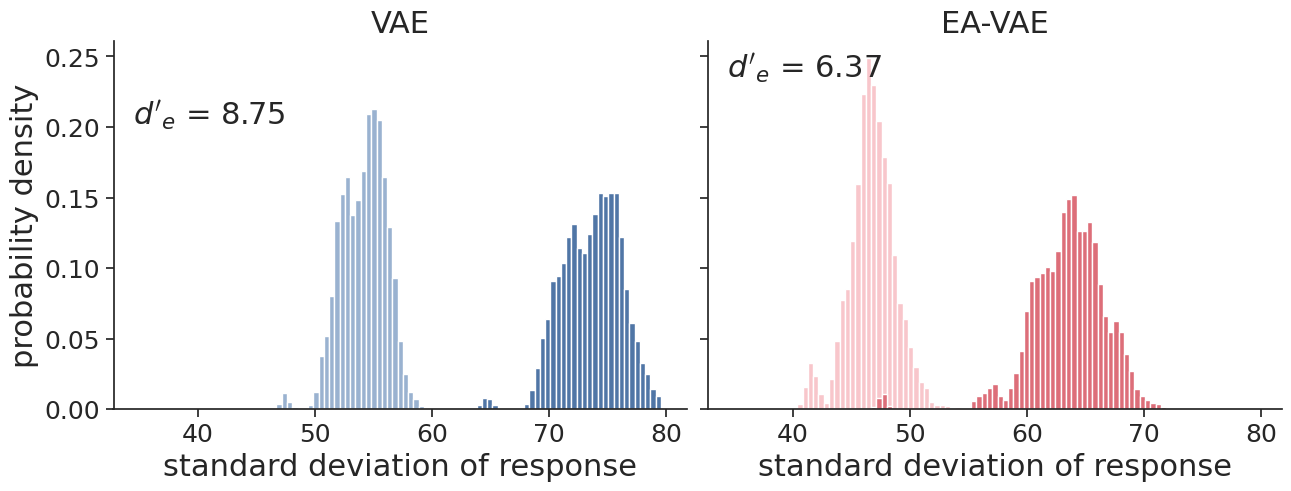

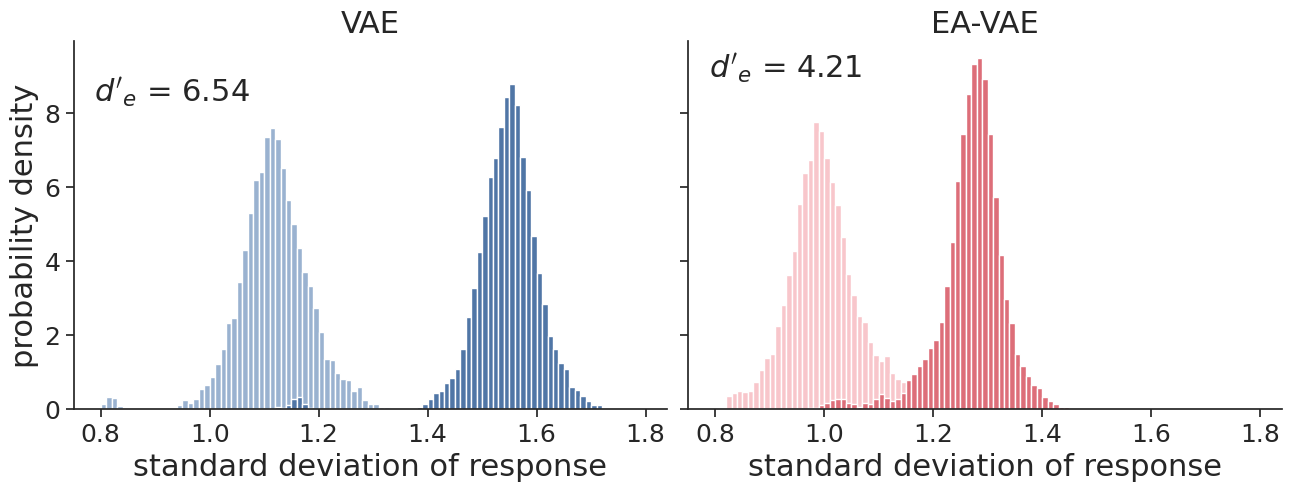

In [12]:
colors = [[[221/255, 110/255, 121/255],[248/255, 198/255, 203/255]],[[80/255, 118/255, 166/255],[154/255, 178/255, 208/255]]]


(linresp_central_stds_standardvae, linresp_flanking_stds_standardvae,
 linresp_central_stds_eavae, linresp_flanking_stds_eavae) = (
 plot_three_violin_std_hists(linear_responses_standardvae,
                             linear_responses_eavae,
                             config['three_violins_std_hists_filter_idcs'],
                             'linear',
                             config['standardvae_modelname'],
                             config['eavae_modelname'],
                             colors,
                             format='png', format2='pdf', histBins = np.divide(range(0,100),100/(80-35))+35, 
                             central_stds_standardvae=three_violins_stds['linresp_central_stds_standardvae'],
                             flanking_stds_standardvae=three_violins_stds['linresp_flanking_stds_standardvae'],
                             central_stds_eavae=three_violins_stds['linresp_central_stds_eavae'],
                             flanking_stds_eavae=three_violins_stds['linresp_flanking_stds_eavae']))

(modelresp_central_stds_standardvae, modelresp_flanking_stds_standardvae,
 modelresp_central_stds_eavae,
 modelresp_flanking_stds_eavae) = (
 plot_three_violin_std_hists(active_postmns_standardvae,
                             active_postmns_eavae,
                             config['three_violins_std_hists_filter_idcs'],
                             'model',
                             config['standardvae_modelname'],
                             config['eavae_modelname'],
                             colors,
                             format='png', format2='pdf', histBins = np.divide(range(0,100),100/(1.8-0.8))+0.8,
                             central_stds_standardvae=three_violins_stds['modelresp_central_stds_standardvae'],
                             flanking_stds_standardvae=three_violins_stds['modelresp_flanking_stds_standardvae'],
                             central_stds_eavae=three_violins_stds['modelresp_central_stds_eavae'],
                             flanking_stds_eavae=three_violins_stds['modelresp_flanking_stds_eavae']))


# Panel C

In [14]:
def plot_w_histograms_cumulative(ws_per_seed, ksps_per_seed, seeds,
                                 format='png'):
    alpha = 0.3
    bins = np.geomspace(1e-7, 1e-1, 61)
    
    colorSMVAE = [221/255, 110/255, 121/255]
    colorVanilla = [80/255, 118/255, 166/255]

    
    sns.set_theme(style="ticks")

    # Plot all matrix elements in $w_{ij}$
    fig, ax = plt.subplots(constrained_layout=True)
    for i_seed, seed in enumerate(seeds):
        ax.hist(ws_per_seed[i_seed]['w_standardvae'].flatten(),
                bins=bins, density=True, histtype='step',
                alpha=alpha, color='C0')
        ax.hist(ws_per_seed[i_seed]['w_standardvae_untrained'].flatten(),
                bins=bins, density=True, histtype='step',
                alpha=alpha, color='C1')
        ax.hist(ws_per_seed[i_seed]['w_eavae'].flatten(),
                bins=bins, density=True, histtype='step',
                alpha=alpha, color='C2')
        ax.hist(ws_per_seed[i_seed]['w_eavae_untrained'].flatten(),
                bins=bins, density=True, histtype='step',
                alpha=alpha, color='C3')

    w_standardvae_all = np.zeros_like(
        ws_per_seed[0]['w_standardvae'], shape=(0,))
    w_standardvae_untrained_all = np.zeros_like(
        ws_per_seed[0]['w_standardvae_untrained'], shape=(0,))
    w_eavae_all = np.zeros_like(
        ws_per_seed[0]['w_eavae'], shape=(0,))
    w_eavae_untrained_all = np.zeros_like(
        ws_per_seed[0]['w_eavae_untrained'], shape=(0,))
    ksps_untrained_all = np.zeros_like(
        ksps_per_seed[0]['ksp_untrained'], shape=(len(seeds)),)
    ksps_trained_all = np.zeros_like(
        ksps_per_seed[0]['ksp_trained'], shape=(len(seeds)),)
    for i_seed, seed in enumerate(seeds):
        w_standardvae_all = np.concatenate(
            (w_standardvae_all,
             ws_per_seed[i_seed]['w_standardvae'].flatten()))
        w_standardvae_untrained_all = np.concatenate(
            (w_standardvae_untrained_all,
             ws_per_seed[i_seed]['w_standardvae_untrained'].flatten()))
        w_eavae_all = np.concatenate(
            (w_eavae_all,
             ws_per_seed[i_seed]['w_eavae'].flatten()))
        w_eavae_untrained_all = np.concatenate(
            (w_eavae_untrained_all,
             ws_per_seed[i_seed]['w_eavae_untrained'].flatten()))
        ksps_untrained_all[i_seed] = ksps_per_seed[i_seed]['ksp_untrained']
        ksps_trained_all[i_seed] = ksps_per_seed[i_seed]['ksp_trained']

    ax.hist(w_standardvae_all,
            bins=bins, density=True, histtype='step',
            label=standardvae_modelname, color = colorVanilla)
    #ax.hist(w_standardvae_untrained_all,
    #        bins=bins, density=True, histtype='step', color='C1',
    #        label=standardvae_modelname + '_untrained')
    ax.hist(w_eavae_all, bins=bins,
            density=True, histtype='step',
            label=eavae_modelname, color = colorSMVAE)
    #ax.hist(w_eavae_untrained_all, bins=bins,
    #        density=True, histtype='step', color='C3',
    #        label=eavae_modelname + '_untrained')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    ax.set_xlabel('$w_{ij}$')
    ax.set_ylabel('probability density')
    fig.suptitle(f'{standardvae_modelname} vs. {eavae_modelname}, random seeds: {seeds}')

    ksp_untrained_mean = np.mean(ksps_untrained_all)
    ksp_untrained_sem = np.std(ksps_untrained_all) / np.sqrt(len(seeds))
    ksp_trained_mean = np.mean(ksps_trained_all)
    ksp_trained_sem = np.std(ksps_trained_all) / np.sqrt(len(seeds))
    ax.set_title(f'Kolmogorov-Smirnov P: '
                 f'untrained: {ksp_untrained_mean:.3g}±'
                 f'{ksp_untrained_sem:.3g}, '
                 f'trained: {ksp_trained_mean:.3g}±'
                 f'{ksp_trained_sem:.3g}')

    fig.savefig(results_dir + f'w_hists_{standardvae_modelname}_{eavae_modelname}_allseeds.{format}', format=format)

    plt.close()

    # Plot only off-diagonal matrix elements in $w_{ij}$
    fig, ax = plt.subplots(constrained_layout=True)
    for i_seed, seed in enumerate(seeds):
        ax.hist(offdiagonal(ws_per_seed[i_seed]['w_standardvae']),
                bins=bins, density=True, histtype='step',
                alpha=alpha, color=colorVanilla)
        #ax.hist(offdiagonal(ws_per_seed[i_seed]['w_standardvae_untrained']),
        #        bins=bins, density=True, histtype='step',
        #        alpha=alpha, color='C1')
        ax.hist(offdiagonal(ws_per_seed[i_seed]['w_eavae']),
                bins=bins, density=True, histtype='step',
                alpha=alpha, color=colorSMVAE)
        #ax.hist(offdiagonal(
        #    ws_per_seed[i_seed]['w_eavae_untrained']),
        #        bins=bins, density=True, histtype='step',
        #        alpha=alpha, color='C3')

    w_standardvae_offdiagonal_all = np.zeros_like(
        ws_per_seed[0]['w_standardvae'], shape=(0,))
    w_standardvae_untrained_offdiagonal_all = np.zeros_like(
        ws_per_seed[0]['w_standardvae_untrained'], shape=(0,))
    w_eavae_offdiagonal_all = np.zeros_like(
        ws_per_seed[0]['w_eavae'], shape=(0,))
    w_eavae_untrained_offdiagonal_all = np.zeros_like(
        ws_per_seed[0]['w_eavae_untrained'], shape=(0,))
    ksps_untrained_offdiagonal_all = np.zeros_like(
        ksps_per_seed[0]['ksp_untrained_offdiagonal'], shape=(len(seeds)),)
    ksps_trained_offdiagonal_all = np.zeros_like(
        ksps_per_seed[0]['ksp_trained_offdiagonal'], shape=(len(seeds)),)
    for i_seed, seed in enumerate(seeds):
        w_standardvae_offdiagonal_all = np.concatenate(
            (w_standardvae_offdiagonal_all,
             offdiagonal(ws_per_seed[i_seed]['w_standardvae'])))
        w_standardvae_untrained_offdiagonal_all = np.concatenate(
            (w_standardvae_untrained_offdiagonal_all,
             offdiagonal(ws_per_seed[i_seed]['w_standardvae_untrained'])))
        w_eavae_offdiagonal_all = np.concatenate(
            (w_eavae_offdiagonal_all,
             offdiagonal(ws_per_seed[i_seed]['w_eavae'])))
        w_eavae_untrained_offdiagonal_all = np.concatenate(
            (w_eavae_untrained_offdiagonal_all,
             offdiagonal(ws_per_seed[i_seed]['w_eavae_untrained'])))
        ksps_untrained_offdiagonal_all[i_seed] = \
            ksps_per_seed[i_seed]['ksp_untrained_offdiagonal']
        ksps_trained_offdiagonal_all[i_seed] = \
            ksps_per_seed[i_seed]['ksp_trained_offdiagonal']

    ax.hist(w_standardvae_offdiagonal_all,
            bins=bins, density=True, histtype='step', color=colorVanilla,
            label='VAE')
    #ax.hist(w_standardvae_untrained_offdiagonal_all,
    #        bins=bins, density=True, histtype='step', color='C1',
    #        label=standardvae_modelname + '_untrained')
    ax.hist(w_eavae_offdiagonal_all, bins=bins,
            density=True, histtype='step', color=colorSMVAE,
            label='EA-VAE')
    #ax.hist(w_eavae_untrained_offdiagonal_all, bins=bins,
    #        density=True, histtype='step', color='C3',
    #        label=eavae_modelname + '_untrained')

    fs = 22
    fs2 = 18
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(frameon=False, fontsize = fs2)
    #ax.set_xlabel('$w_{ij}, i \\neq j$',fontsize=fs)
    ax.set_xlabel('$w_{ij}$',fontsize=fs)
    ax.set_ylabel('probability density',fontsize=fs)
    #fig.suptitle(f'{standardvae_modelname} vs. {eavae_modelname}, random seeds: {seeds}',fontsize=fs)

    
    #ax.set_xlim([-0.5, T+0.5])
    #ax.set_ylim([-0.5, 5])
    #ax.set_xticks([0, 1, 2, 3])
    ax.tick_params(axis='both', which='major', labelsize=fs2)

    #ax.legend()
    
    sns.despine(trim=False, left=False)

    
    ksp_untrained_offdiagonal_mean = np.mean(ksps_untrained_offdiagonal_all)
    ksp_untrained_offdiagonal_sem = np.std(ksps_untrained_offdiagonal_all) \
        / np.sqrt(len(seeds))
    ksp_trained_offdiagonal_mean = np.mean(ksps_trained_offdiagonal_all)
    ksp_trained_offdiagonal_sem = np.std(ksps_trained_offdiagonal_all) \
        / np.sqrt(len(seeds))
    #ax.set_title(f'Kolmogorov-Smirnov P: '
    #             f'untrained: {ksp_untrained_offdiagonal_mean:.3g}±'
    #             f'{ksp_untrained_offdiagonal_sem:.3g}, '
    #             f'trained: {ksp_trained_offdiagonal_mean:.3g}±'
    #             f'{ksp_trained_offdiagonal_sem:.3g}')

    fig.show() 
    fig.savefig(results_dir + f'w_offdiagonal_hists_'
                f'{standardvae_modelname}_{eavae_modelname}_allseeds.{format}', format=format, dpi=300)
    fig.savefig(config['smvae_data_dir'] + f'w_offdiagonal_hists_' + f'{standardvae_modelname}_{eavae_modelname}_allseeds.pdf', format='pdf', dpi=400)
    fig.savefig(config['smvae_data_dir'] + f'w_offdiagonal_hists_' + f'{standardvae_modelname}_{eavae_modelname}_allseeds.png', format='png', dpi=400)

    #plt.close()

In [15]:
def offdiagonal(a):
    "Returns the off-diagonal elements of array a as a 1D array."
    return np.concatenate((np.triu(a, k=1), np.tril(a, k=-1)), axis=None)


def load_ws(seed):
    w_standardvae_untrained = pickle.load(open(results_dir + f'w_standardvae_untrained_{standardvae_modelname}_seed{seed}.pkl', 'rb'))
    w_standardvae = pickle.load(open(results_dir + f'w_standardvae_{standardvae_modelname}_seed{seed}.pkl', 'rb'))
    w_eavae_untrained = pickle.load(open(results_dir + f'w_eavae_untrained_{eavae_modelname}_seed{seed}.pkl', 'rb'))
    w_eavae = pickle.load(open(results_dir + f'w_eavae_{eavae_modelname}_seed{seed}.pkl', 'rb'))

    ksp_untrained = stats.kstest(w_standardvae_untrained, w_eavae_untrained, axis=None).pvalue
    ksp_trained = stats.kstest(w_standardvae, w_eavae, axis=None).pvalue

    ksp_untrained_offdiagonal = stats.kstest(
        offdiagonal(w_standardvae_untrained), offdiagonal(w_eavae_untrained), axis=None).pvalue
    ksp_trained_offdiagonal = stats.kstest(
        offdiagonal(w_standardvae), offdiagonal(w_eavae), axis=None).pvalue

    return {
        'w_standardvae_untrained': w_standardvae_untrained,
        'w_standardvae': w_standardvae,
        'w_eavae_untrained': w_eavae_untrained,
        'w_eavae': w_eavae,
    }, {
        'ksp_untrained': ksp_untrained,
        'ksp_trained': ksp_trained,
        'ksp_untrained_offdiagonal': ksp_untrained_offdiagonal,
        'ksp_trained_offdiagonal': ksp_trained_offdiagonal,
    }

/tmp/ipykernel_1629327/3605651618.py:183: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


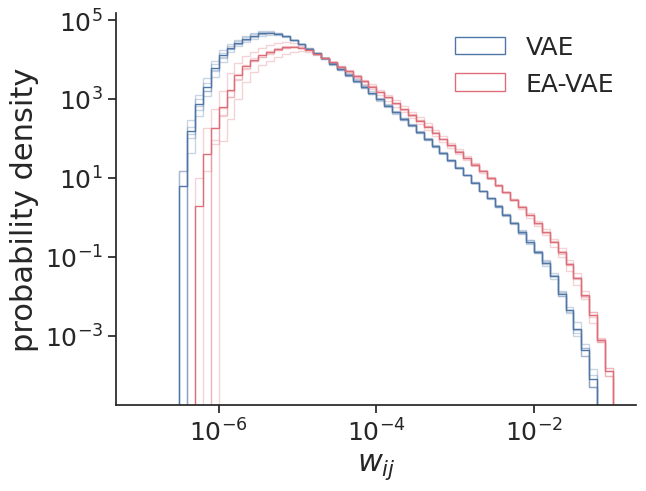

In [ ]:
# load fitted weights for the [Schwartz 2001] model

random_seeds = [42, 43, 44, 45, 46]
ws_per_seed = []
ksps_per_seed = []

for seed in random_seeds:
    ws, ksps = load_ws(seed)
    ws_per_seed.append(ws)
    ksps_per_seed.append(ksps)

plot_w_histograms_cumulative(ws_per_seed, ksps_per_seed, random_seeds, format='pdf')
#plot_w_histograms_cumulative(ws_per_seed, ksps_per_seed, random_seeds, format='pdf')

# Panels D, E, F, G, H

In [40]:
standardvae_modelname = 'StandardVAE'
eavae_modelname = 'EAVAE_lognormal'

config = {
    'image_sample_fn': results_dir + 'image_samples40.png',
    f'recf_{standardvae_modelname}_sample_fn': results_dir + f'recf_{standardvae_modelname}_samples.png',
    f'recf_{eavae_modelname}_sample_fn': (results_dir +
                                     f'recf_{eavae_modelname}_samples.png'),
    f'recf_{standardvae_modelname}_active_fn_pre': results_dir + f'recf_{standardvae_modelname}_',
    f'recf_{eavae_modelname}_active_fn_pre': results_dir + f'recf_{eavae_modelname}_',

    'scatterplot_fn_pre': results_dir +     'modelresp_vs_linresp_',
    'slopeplot_fn_pre': results_dir + 'slope_vs_posteriornorm_',
    'slopeplot_contrast_fn_pre': results_dir + 'slope_vs_imgcontrast_',

    'active_recfs_threshold': 0.3,
    'sigma_obs': 0.4,

    'standardvae_modelname': standardvae_modelname,
    'eavae_modelname': eavae_modelname, 

    'standardvae_ims_fn': f'/{standardvae_modelname}_natural_ims.pt',
    'standardvae_recfs_fn': f'/{standardvae_modelname}_receptive_fields.pt',
    'standardvae_postmns_fn': f'/{standardvae_modelname}_posterior_natural.pt',

    'eavae_ims_fn': f'/{eavae_modelname}_natural_ims.pt',
    'eavae_recfs_fn': f'/{eavae_modelname}_receptive_fields.pt',
    'eavae_postmns_fn': f'/{eavae_modelname}_z_posterior_natural.pt',

    'smvae_data_dir': os.path.join(root, '/eval_data/DN/'),

    'vminmax_imgs': 3.0,
    'vminmax_recfs': 6.0,
}

In [41]:
from matplotlib.colors import LinearSegmentedColormap

cmap_bright = sns.color_palette(['#4477AA', '#66CCEE', '#228833', '#CCBB44','#EE6677','#BBBBBB'],6)
cmap_pale = sns.color_palette(['#BBCCEE', '#CCEEFF', '#CCDDAA', '#EEEEBB','#FFCCCC','#DDDDDD'],6)
cmap_dark = sns.color_palette(['#222255', '#225555', '#225522', '#666633','#663333','#555555'],6)

cmap_bright_vae_eavae = sns.color_palette(['#4477AA','#EE6677'],2)
cmap_pale_vae_eavae = sns.color_palette(['#BBCCEE','#FFCCCC'],2)
cmap_dark_vae_eavae = sns.color_palette(['#222255','#663333'],2)

def custom_colormap_blue():
        colors_blue = ['#BBCCEE', '#4477AA', '#222255']
        cm_blue = LinearSegmentedColormap.from_list(
                "Custom_blue", colors_blue, N=255)
        cm_blue.set_bad('#FFFFFF')
        #plt.register_cmap(cmap=cm_blue)
        return cm_blue
def custom_colormap_red():
        colors_red = ['#FFCCCC', '#EE6677', '#663333']
        cm_red = LinearSegmentedColormap.from_list(
                "Custom_red", colors_red, N=255)
        cm_red.set_bad('#FFFFFF')
        #plt.register_cmap(cmap=cm_red)
        return cm_red

def save_samples_png(samps, fn=None, vminmax=1.0):
    # Saves samps to fn
    n_rows = n_cols = math.ceil(math.sqrt(samps.shape[0]))

    if samps.ndim == 2:
        xdim = int(math.sqrt(samps.shape[1]))
        samps = samps.reshape((samps.shape[0], xdim, xdim))

    fig, axs = plt.subplots(n_rows, n_cols, constrained_layout=True,
                            figsize=(10, 10))
    for i_row in range(n_rows):
        for i_col in range(n_cols):
            i_lin = i_row * n_cols + i_col
            ax = axs[i_row, i_col]
            ax.set_xticks([])
            ax.set_yticks([])
            if i_lin < samps.shape[0]:
                img = samps[i_lin, :, :]
                ax.imshow(img, cmap='gray', vmin=-vminmax, vmax=vminmax)

    if fn:
        fig.savefig(fn)


def load_test_images(ims_fn):
    # Load test images (natural, whitened)
    with open(config['smvae_data_dir'] + ims_fn, 'rb') as f:
        if ims_fn.endswith('.pt'):
            test_ims = torch.load(f, map_location='cpu').detach().numpy()
        else:
            test_ims = pickle.load(f).detach().numpy()

    if test_ims.ndim >= 3:
        test_ims = test_ims.reshape((test_ims.shape[0], -1))

    print('loaded test images')
    print(f'  shape: {test_ims.shape}; dtype: {test_ims.dtype}')
    print(f'  pixel mean: {np.mean(test_ims):.5f}; '
          f'std: {np.std(test_ims):.5f}')

    n_samps_sqrt = 5
    save_samples_png(
        test_ims[:n_samps_sqrt * n_samps_sqrt, :],
        config['image_sample_fn'], config['vminmax_imgs'])
    print(f'  saved {n_samps_sqrt}x{n_samps_sqrt} image samples '
          f'to {config["image_sample_fn"]}')

    return test_ims


def load_recfs(recf_fn, model_name, sample_fn):
    # Load receptive fields
    with open(config['smvae_data_dir'] + recf_fn, 'rb') as f:
        if recf_fn.endswith('.pt'):
            recfs = torch.load(f, map_location='cpu')
        else:
            recfs = pickle.load(f)

    if recfs.ndim == 3:
        recfs = recfs.reshape((recfs.shape[0],
                               recfs.shape[1] * recfs.shape[2]))

    print(f'loaded recfields for {model_name}')
    print(f'  shape: {recfs.shape}; dtype: {recfs.dtype}')
    print(f'  mean: {np.mean(recfs):.5f}; '
          f'std: {np.std(recfs):.5f}')

    n_samps_sqrt = 5
    save_samples_png(
        recfs[:n_samps_sqrt * n_samps_sqrt, :],
        sample_fn, config['vminmax_recfs'])
    print(f'  saved {n_samps_sqrt}x{n_samps_sqrt} image samples '
          f'to {sample_fn}')

    return recfs


def load_postmns(postmn_fn, model_name):
    # Load posterior means
    with open(config['smvae_data_dir'] + postmn_fn, 'rb') as f:
        if postmn_fn.endswith('.pt'):
            postmns = torch.load(f, map_location='cpu').detach().numpy()
        else:
            postmns = pickle.load(f).detach().numpy()

    print(f'loaded postmns for {model_name}')
    print(f'  shape: {postmns.shape}; dtype: {postmns.dtype}')
    print(f'  mean: {np.mean(postmns):.5f}; '
          f'std: {np.std(postmns):.5f}')

    return postmns


def active_recfs_postmns(recfs, postmns, threshold=1.0, fn_pre=None,
                         model_name=None):
    active_recfs = recfs[np.std(recfs, axis=1) >= threshold, :]
    active_postmns = postmns[:, np.std(recfs, axis=1) >= threshold]

    inactive_recfs = recfs[np.std(recfs, axis=1) < threshold, :]
    inactive_postmns = postmns[:, np.std(recfs, axis=1) < threshold]

    if fn_pre:
        save_samples_png(
            active_recfs, fn_pre + 'active.png', config['vminmax_recfs'])
        save_samples_png(
            inactive_recfs, fn_pre + 'inactive.png', config['vminmax_recfs'])

    if model_name:
        print(f'found {active_recfs.shape[0]} active and '
              f'{inactive_recfs.shape[0]} inactive z dims '
              f'for {model_name}')

    return active_recfs, active_postmns, inactive_recfs, inactive_postmns


def plot_modelresp_vs_linresp_linfit(
        imgs, linear_resps, postmns, img_idcs, model_name, colorPalette, format='png'):
    fig, ax = plt.subplots()

    sns.set_theme(style="ticks")

    ax.axvline(x=0, color='k', lw=1)
    ax.axhline(y=0, color='k', lw=1)
    
    contrasts = np.std(imgs[img_idcs, :], axis=1)
    contrasts_normed = contrasts / np.max(contrasts)
    cmap = plt.get_cmap(colorPalette)
    
    cm_blue = custom_colormap_blue()
    cm_red = custom_colormap_red()

    color_vae = cmap_bright[0]
    color_eavae = cmap_bright[4]
    
    if model_name == 'EA-VAE':
        cmAct = custom_colormap_red()
    else:
        cmAct = custom_colormap_blue()

    for i_img, ii_img in enumerate(img_idcs):
        slope = LinearRegression(fit_intercept=False).fit(
            linear_resps[i_img, :].reshape((-1, 1)),
            postmns[i_img, :]).coef_[0]
        color = cmAct(contrasts_normed[ii_img])
        #color = cmap(contrasts_normed[ii_img])
        #ax.scatter(linear_resps[i_img, :], postmns[i_img, :], s=1,
        #           label=f'img {i_img}: '
        #           f'contrast: {contrasts[ii_img]:.3f}, '
        #           f'slope: {slope:.3g}', color=color)
        #ax.axline([0, 0], [1, slope], lw=1, color=color)

        ax.scatter(linear_resps[i_img, :], postmns[i_img, :], s=1, color=color)
        ax.axline([0, 0], [1, slope], lw=1,
                    label=f'img {i_img+1}: '
                    f'contrast: {contrasts[ii_img]:.3f}, ', color=color)

        
    fs = 22
    fs2 = 18
    ax.set_title(model_name,fontsize=fs)
    ax.set_xlabel('linear responses',fontsize=fs)
    ax.set_ylabel('model responses',fontsize=fs)
    ax.legend(fontsize=fs2, loc='lower right', bbox_to_anchor=(1.9, 0.3))
    ax.set_xticks([-200, 0, 200])
    ax.set_yticks([-6, 0, 6])

    ax.tick_params(axis='both', which='major', labelsize=fs2)
    
    sns.despine(trim=True, left=False)

    fig.show()
    
    fig.savefig(config['scatterplot_fn_pre']
                + f'{model_name}.{format}', format=format, dpi=300, bbox_inches='tight')
    fig.savefig(config['scatterplot_fn_pre'], format='pdf', dpi=400, bbox_inches='tight')
    fig.savefig(config['scatterplot_fn_pre'], format='png', dpi=400, bbox_inches='tight')

    #plt.close()


def plot_slope_vs_imgcontrast(
        imgs, linear_resps, postmns, model_name,dotColor, format='png', format2='pdf'):
    sns.set_theme(style="ticks")
    fig, ax = plt.subplots(constrained_layout=True)

    slopes_per_imgs = np.zeros_like(linear_resps,
                                    shape=(linear_resps.shape[0],))
    imgcontrasts = np.zeros_like(slopes_per_imgs)
    for i_img in range(linear_resps.shape[0]):
        slopes_per_imgs[i_img] = LinearRegression(fit_intercept=False).fit(
            linear_resps[i_img, :].reshape((-1, 1)),
            postmns[i_img, :]).coef_[0]
        imgcontrasts[i_img] = np.std(imgs[i_img, :])

    ax.scatter(imgcontrasts, slopes_per_imgs, s=1, color=dotColor)

    fs = 22
    fs2 = 18
    ax.set_title(model_name,fontsize=fs)
    ax.set_xlabel('contrast',fontsize=fs)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_ylabel('normalization index',fontsize=fs)
    ax.axvline(x=config['sigma_obs'], color='darkgrey', lw=2)
    #ax.text(config['sigma_obs'] + 0.05, 0.008, 'observation noise',fontsize=fs)

    ax.tick_params(axis='both', which='major', labelsize=fs2)
    
    sns.despine(trim=True, left=False)
    
    fig.show()
    
    fig.savefig(config['slopeplot_contrast_fn_pre']
                + f'{model_name}.{format}', format=format, dpi=400)
    fig.savefig(config['slopeplot_contrast_fn_pre']
                + f'{model_name}.{format2}', format=format2, dpi=400)

    #plt.close()


def plot_slope_vs_posteriornorm(
        imgs, linear_resps, postmns, model_name, colors, format='png', format2='pdf'):
    sns.set_theme(style="ticks")
    fig, ax = plt.subplots(constrained_layout=True)

    slopes_per_imgs = np.zeros_like(linear_resps,
                                    shape=(linear_resps.shape[0],))
    posteriornorms_per_imgs = np.zeros_like(slopes_per_imgs)

    for i_img in range(linear_resps.shape[0]):
        slopes_per_imgs[i_img] = LinearRegression(fit_intercept=False).fit(
            linear_resps[i_img, :].reshape((-1, 1)),
            postmns[i_img, :]).coef_[0]
        posteriornorms_per_imgs[i_img] = np.linalg.norm(postmns[i_img, :])

    ax.scatter(posteriornorms_per_imgs, slopes_per_imgs, s=1,
               label='all images',color=colors[1])
    ax.scatter(posteriornorms_per_imgs[np.std(imgs, axis=1)
                                       >= config['sigma_obs']],
               slopes_per_imgs[np.std(imgs, axis=1) >= config['sigma_obs']],
               s=1, label='images with nonvanishing contrasts', color=colors[0])
    
    fs = 18
    fs2 = 14
    ax.set_title(model_name,fontsize=fs)
    ax.set_xlabel('L2 norm of posterior means',fontsize=fs)
    ax.set_ylabel('normalization index',fontsize=fs)
    
    #ax.set_xlim([-0.5, T+0.5])
    #ax.set_ylim([-0.5, 5])
    #ax.set_xticks([0, 1, 2, 3])
    ax.tick_params(axis='both', which='major', labelsize=fs2)

    #ax.legend()
    
    sns.despine(trim=True, left=False)
    
    fig.show()

    fig.savefig(config['slopeplot_fn_pre']
                + f'{model_name}.{format}', format=format, dpi=400)
    fig.savefig(config['slopeplot_fn_pre']
                + f'{model_name}.{format2}', format=format2, dpi=400)

    #plt.close()

loaded test images
  shape: (64000, 1600); dtype: float32
  pixel mean: -0.00000; std: 0.88600
  saved 5x5 image samples to /app/divisivenorm/results/image_samples40.png
loaded recfields for StandardVAE
  shape: (1800, 1600); dtype: float32
  mean: -0.00085; std: 1.46185
  saved 5x5 image samples to /app/divisivenorm/results/recf_StandardVAE_samples.png
loaded postmns for StandardVAE
  shape: (64000, 1800); dtype: float32
  mean: -0.00004; std: 1.12829
found 1256 active and 544 inactive z dims for StandardVAE
calculated linear responses for StandardVAE
  shape: (64000, 1256); dtype: float32
  mean: 0.00000; std: 64.47011


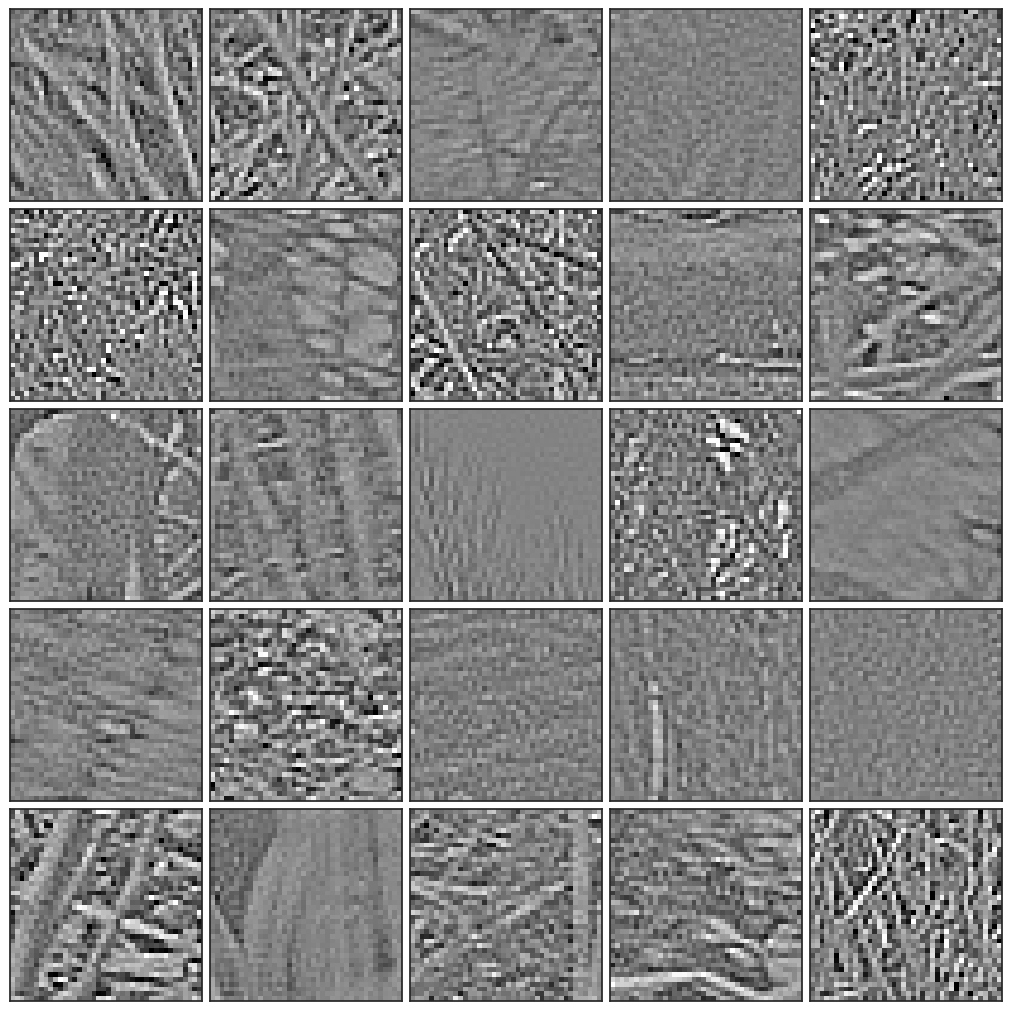

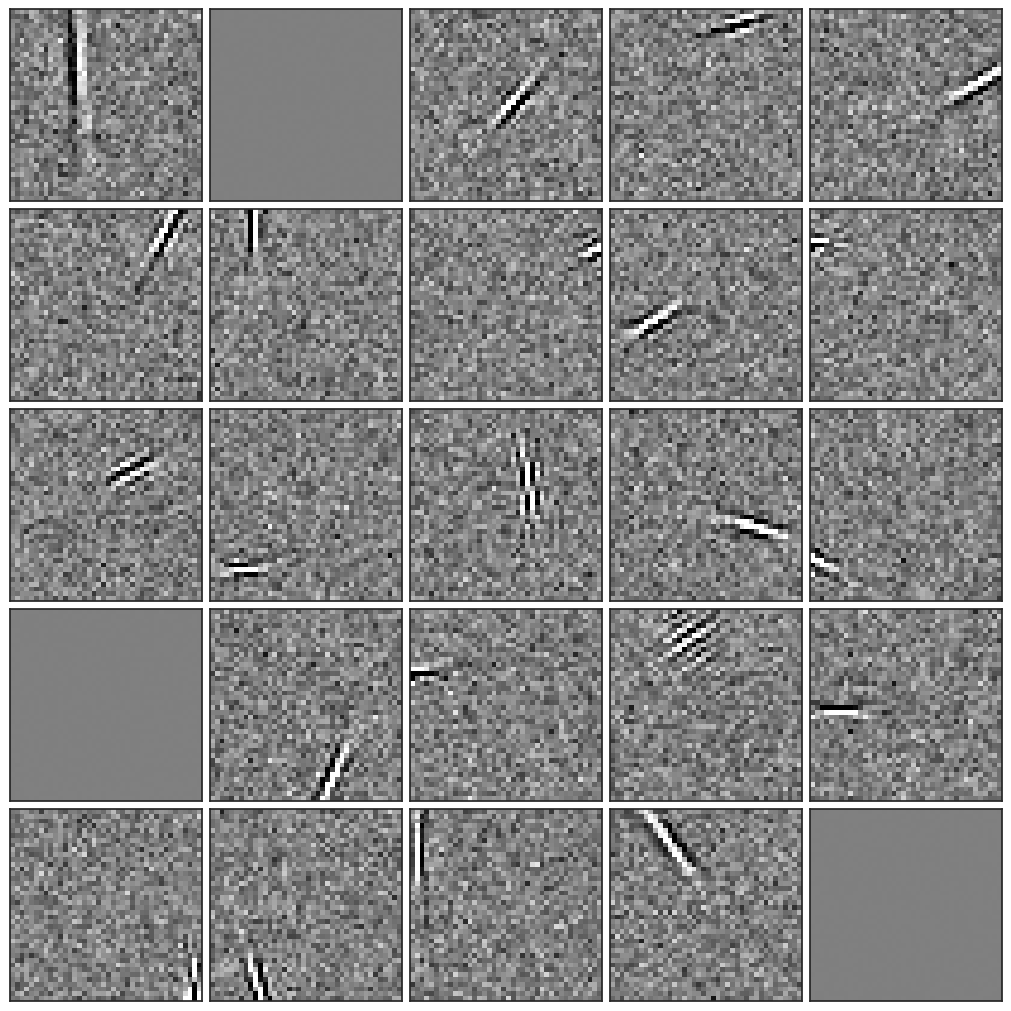

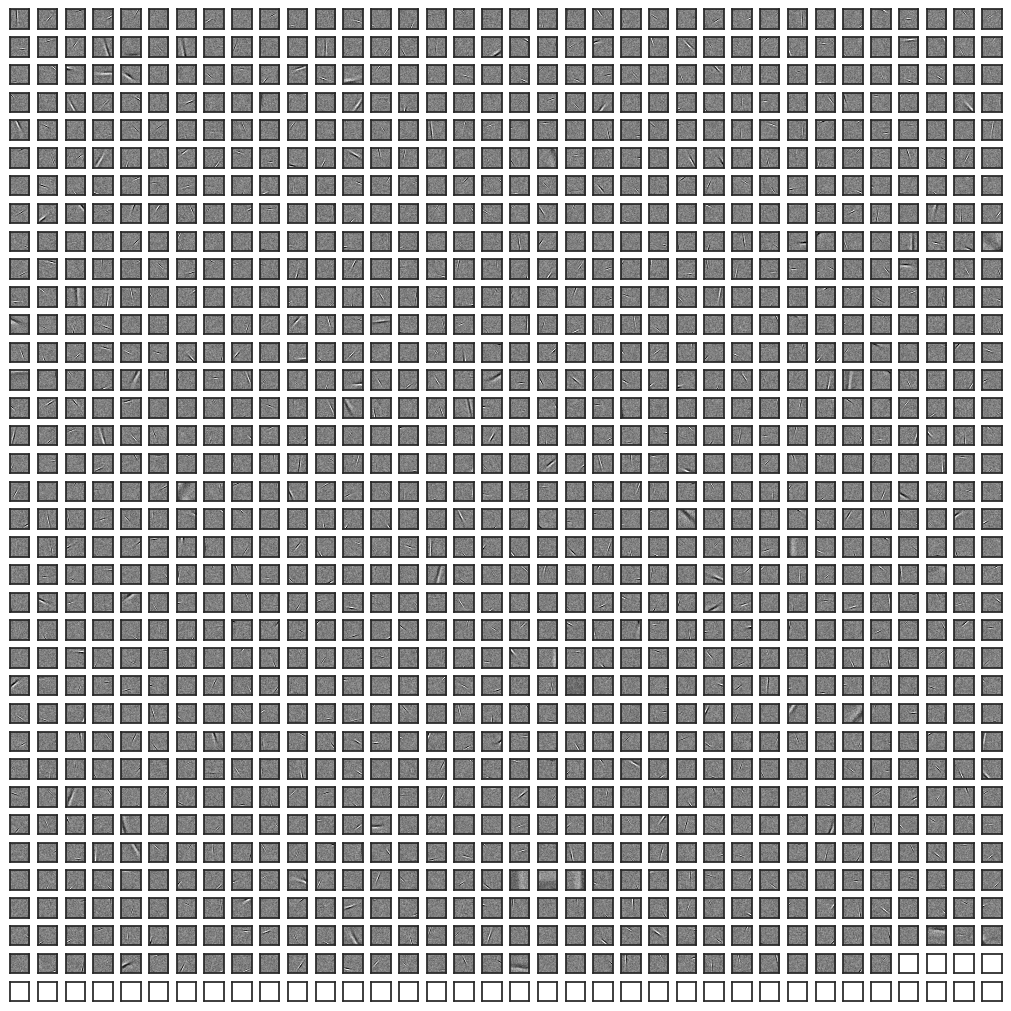

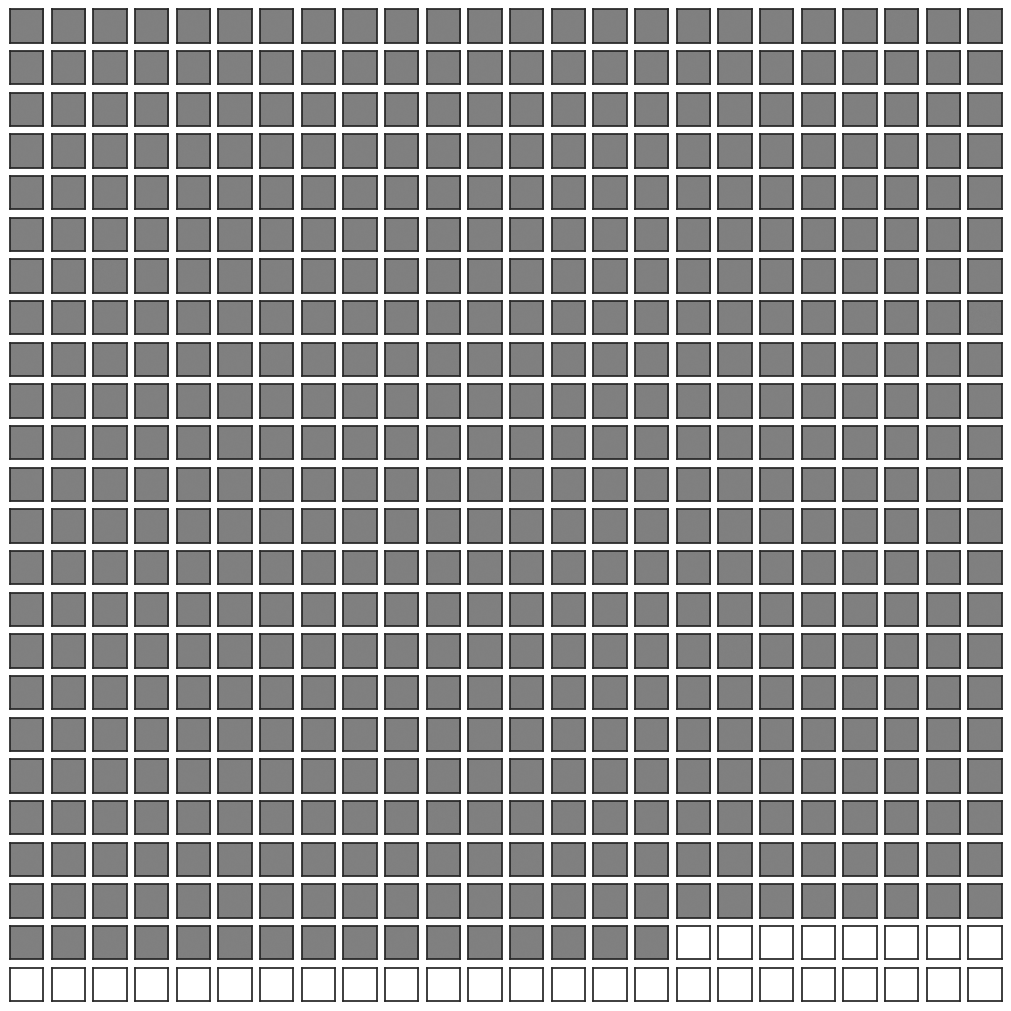

In [42]:
# standardvae
model_name_standardvae = config['standardvae_modelname']

if 'standardvae_ims_fn' in config:
    test_ims_standardvae = load_test_images(
        f'{model_name_standardvae}{config["standardvae_ims_fn"]}')
else:
    test_ims_standardvae = load_test_images(
        f'{model_name_standardvae}_input_ims.pkl')
if 'standardvae_recfs_fn' in config:
    recfs_standardvae = load_recfs(
        f'{model_name_standardvae}{config["standardvae_recfs_fn"]}',
        model_name_standardvae,
        config[f'recf_{model_name_standardvae}_sample_fn'])
else:
    recfs_standardvae = load_recfs(
        f'{model_name_standardvae}_receptive.pkl', model_name_standardvae,
        config[f'recf_{model_name_standardvae}_sample_fn'])
if 'standardvae_postmns_fn' in config:
    postmns_standardvae = load_postmns(
        f'{model_name_standardvae}{config["standardvae_postmns_fn"]}',
        model_name_standardvae)
else:
    postmns_standardvae = load_postmns(
        f'{model_name_standardvae}_posteriors_cpu.pkl',
        model_name_standardvae)

# harmonize data following the instructions from Domo
if test_ims_standardvae.shape[0] != postmns_standardvae.shape[0]:
    print('the number of images and posteriors differ; '
          'using the smaller number everywhere')
    n_ims = min(test_ims_standardvae.shape[0], postmns_standardvae.shape[0])
    test_ims_standardvae = test_ims_standardvae[:n_ims, :]
    postmns_standardvae = postmns_standardvae[:n_ims, :]
if recfs_standardvae.shape[0] != postmns_standardvae.shape[1]:
    print('the number of z dims in receptive fields and posteriors '
          'differ; using the smaller number everywhere')
    n_zdims = min(recfs_standardvae.shape[0], postmns_standardvae.shape[1])
    recfs_standardvae = recfs_standardvae[:n_zdims, :]
    postmns_standardvae = postmns_standardvae[:, :n_zdims]

active_recfs_standardvae, active_postmns_standardvae, \
    inactive_recfs_standardvae, inactive_postmns_standardvae = \
    active_recfs_postmns(
        recfs_standardvae, postmns_standardvae,
        config['active_recfs_threshold'],
        config[f'recf_{model_name_standardvae}_active_fn_pre'],
        model_name_standardvae)

linear_responses_standardvae = np.matmul(
    test_ims_standardvae, active_recfs_standardvae.T)
print(f'calculated linear responses for {model_name_standardvae}')
print(f'  shape: {linear_responses_standardvae.shape}; '
      f'dtype: {linear_responses_standardvae.dtype}')
print(f'  mean: {np.mean(linear_responses_standardvae):.5f}; '
      f'std: {np.std(linear_responses_standardvae):.5f}')

loaded test images
  shape: (64000, 1600); dtype: float32
  pixel mean: -0.00000; std: 0.88600


  saved 5x5 image samples to /app/divisivenorm/results/image_samples40.png
loaded recfields for EAVAE_lognormal
  shape: (1800, 1600); dtype: float32
  mean: 0.00080; std: 1.27218
  saved 5x5 image samples to /app/divisivenorm/results/recf_EAVAE_lognormal_samples.png
loaded postmns for EAVAE_lognormal
  shape: (64000, 1799); dtype: float32
  mean: -0.00097; std: 0.95447
the number of z dims in receptive fields and posteriors differ; using the smaller number everywhere
found 1256 active and 543 inactive z dims for EAVAE_lognormal
calculated linear responses for EAVAE_lognormal
  shape: (64000, 1256); dtype: float32
  mean: 0.00000; std: 56.09657


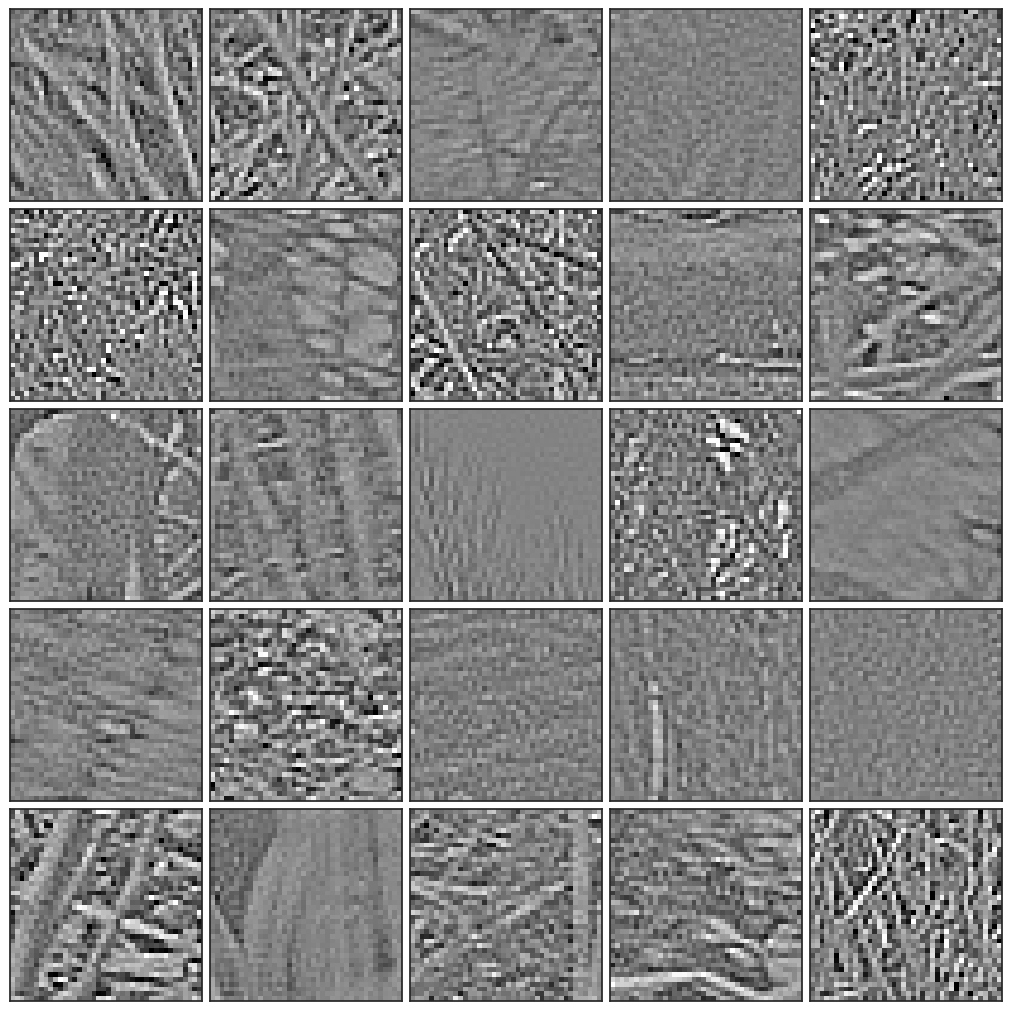

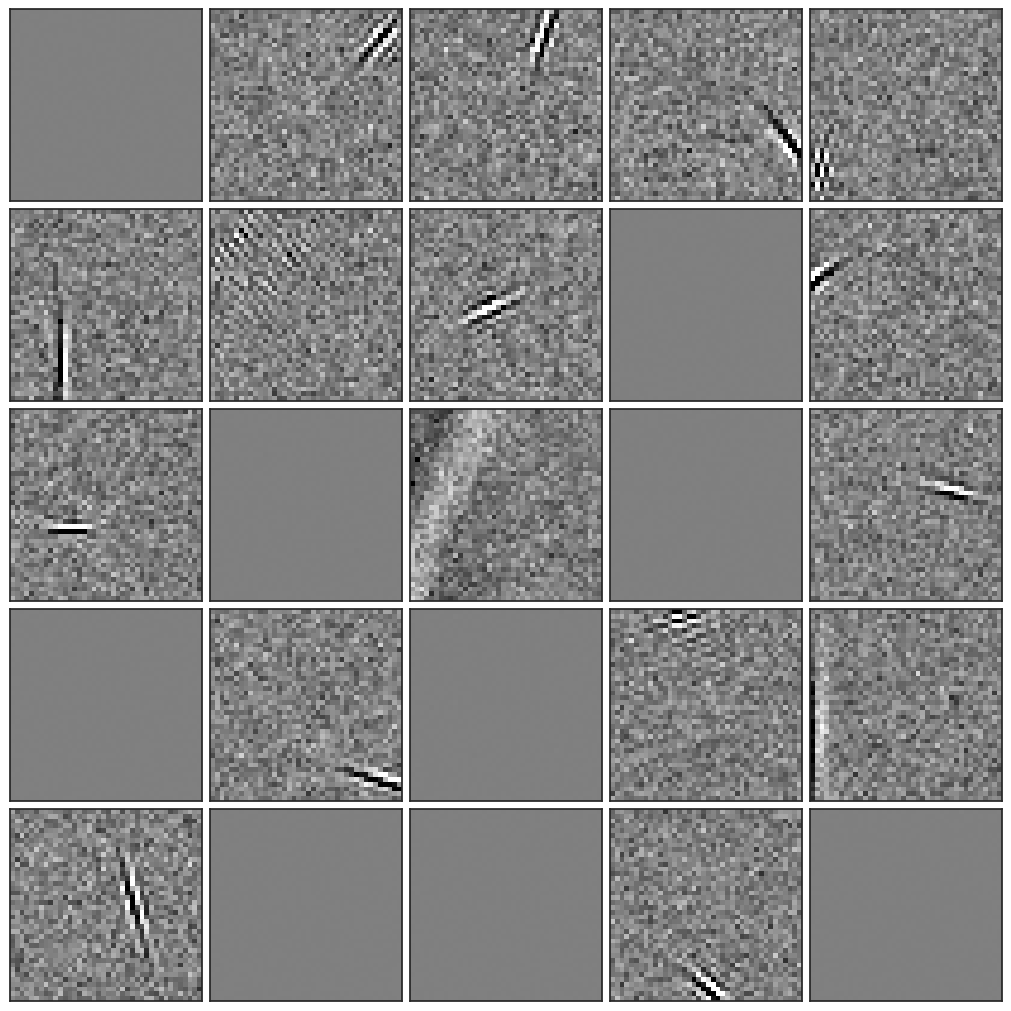

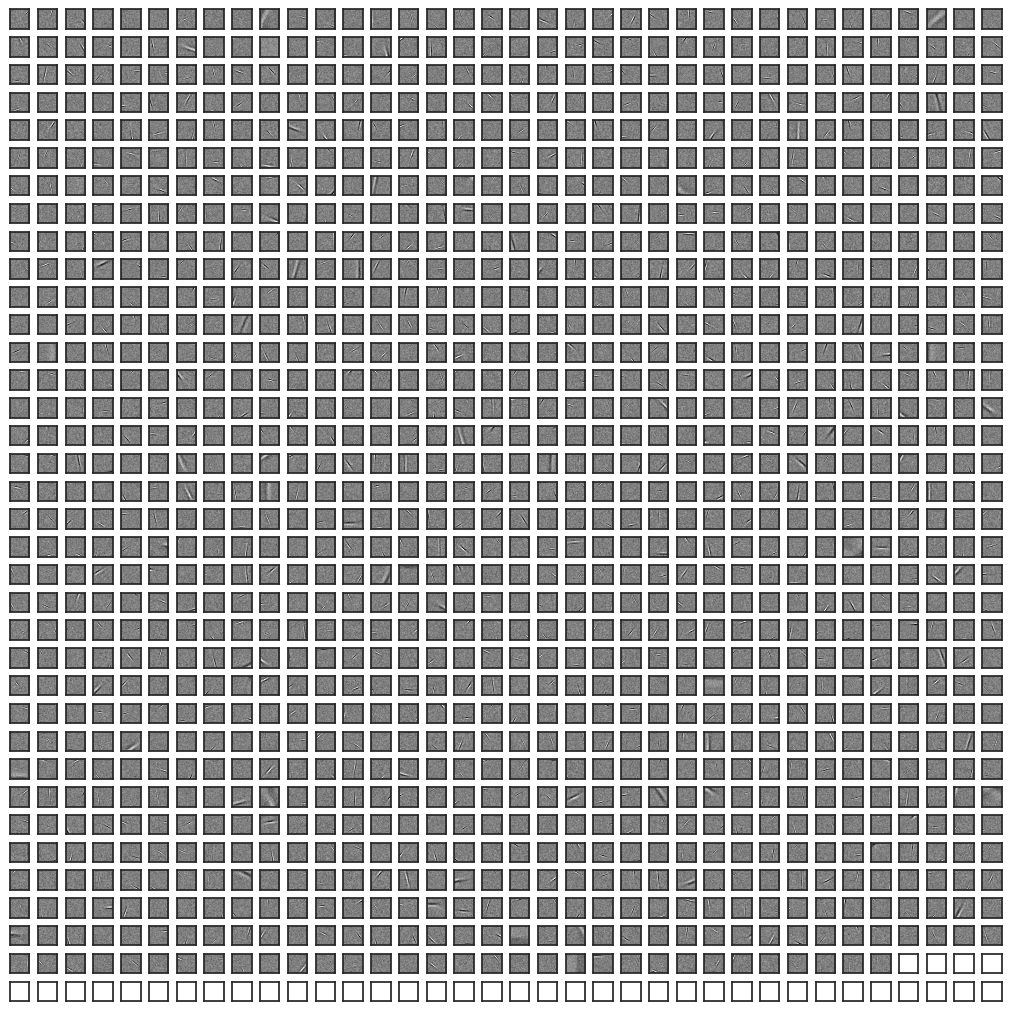

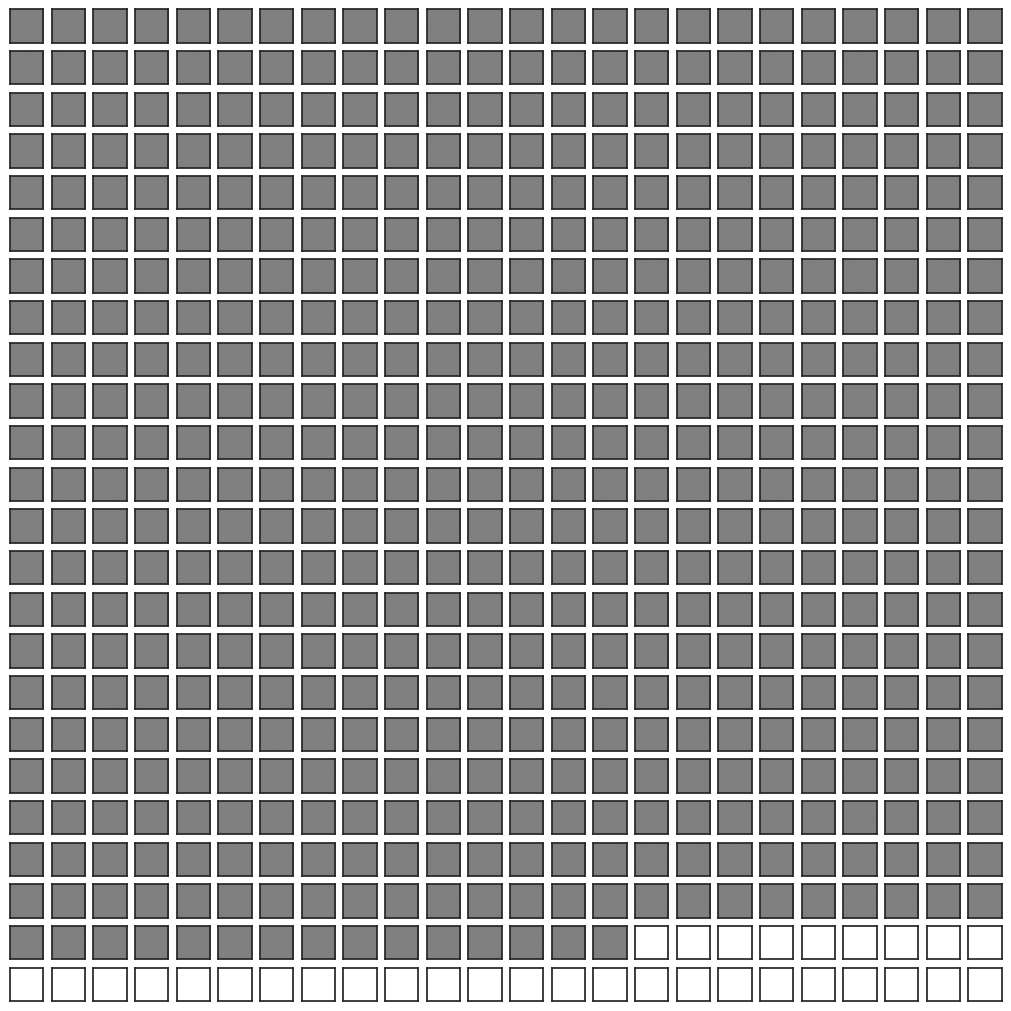

In [43]:
# eavae
model_name_eavae = config['eavae_modelname']
if 'eavae_ims_fn' in config:
    test_ims_eavae = load_test_images(
        f'{model_name_eavae}{config["eavae_ims_fn"]}')
else:
    test_ims_eavae = load_test_images(
        f'{model_name_eavae}_input_ims.pkl')
if 'eavae_recfs_fn' in config:
    recfs_eavae = load_recfs(
        f'{model_name_eavae}{config["eavae_recfs_fn"]}',
        model_name_eavae,
        config[f'recf_{model_name_eavae}_sample_fn'])
else:
    recfs_eavae = load_recfs(
        f'{model_name_eavae}_receptive.pkl', model_name_eavae,
        config[f'recf_{model_name_eavae}_sample_fn'])
if 'eavae_postmns_fn' in config:
    postmns_eavae = load_postmns(
        f'{model_name_eavae}{config["eavae_postmns_fn"]}',
        model_name_eavae)
else:
    postmns_eavae = load_postmns(
        f'{model_name_eavae}_posteriors_cpu.pkl',
        model_name_eavae)

# harmonize data following the instructions from Domo
if test_ims_eavae.shape[0] != postmns_eavae.shape[0]:
    print('the number of images and posteriors differ; '
          'using the smaller number everywhere')
    n_ims = min(test_ims_eavae.shape[0],
                postmns_eavae.shape[0])
    test_ims_eavae = test_ims_eavae[:n_ims, :]
    postmns_eavae = postmns_eavae[:n_ims, :]
if recfs_eavae.shape[0] != postmns_eavae.shape[1]:
    print('the number of z dims in receptive fields and posteriors '
          'differ; using the smaller number everywhere')
    n_zdims = min(recfs_eavae.shape[0], postmns_eavae.shape[1])
    recfs_eavae = recfs_eavae[:n_zdims, :]
    postmns_eavae = postmns_eavae[:, :n_zdims]

active_recfs_eavae, active_postmns_eavae, \
    inactive_recfs_eavae, inactive_postmns_eavae = \
    active_recfs_postmns(
        recfs_eavae, postmns_eavae,
        config['active_recfs_threshold'],
        config[f'recf_{model_name_eavae}_active_fn_pre'],
        model_name_eavae)

linear_responses_eavae = np.matmul(
    test_ims_eavae, active_recfs_eavae.T)
print(f'calculated linear responses for {model_name_eavae}')
print(f'  shape: {linear_responses_eavae.shape}; '
      f'dtype: {linear_responses_eavae.dtype}')
print(f'  mean: {np.mean(linear_responses_eavae):.5f}; '
      f'std: {np.std(linear_responses_eavae):.5f}')

In [44]:
def plot_modelresp_vs_linresp_linfit(
        imgs, linear_resps, postmns, img_idcs, model_name, format='png'):
    fig, ax = plt.subplots(constrained_layout=True)

    ax.axvline(x=0, color='k', lw=1)
    ax.axhline(y=0, color='k', lw=1)

    contrasts = np.std(imgs[img_idcs, :], axis=1)
    contrasts_normed = contrasts / np.max(contrasts)
    cmap = plt.get_cmap('Blues')

    for i_img, ii_img in enumerate(img_idcs):
        slope = LinearRegression(fit_intercept=False).fit(
            linear_resps[i_img, :].reshape((-1, 1)),
            postmns[i_img, :]).coef_[0]
        color = cmap(contrasts_normed[ii_img])
        ax.scatter(linear_resps[i_img, :], postmns[i_img, :], s=1,
                   label=f'img {i_img}: '
                   f'contrast: {contrasts[ii_img]:.3f}, '
                   f'slope: {slope:.3g}', color=color)
        ax.axline([0, 0], [1, slope], lw=1, color=color)

    ax.set_title(model_name)
    ax.set_xlabel('Linear responses')
    ax.set_ylabel('Model responses')
    ax.legend()

    fig.savefig(config['scatterplot_fn_pre']
                + f'{model_name}.{format}', format=format)
    fig.savefig(config['scatterplot_fn_pre'] + f'{model_name}.png', format='png', dpi=400)
    fig.savefig(config['scatterplot_fn_pre'] + f'{model_name}.pdf', format='pdf', dpi=400)
    plt.close()

In [45]:
plot_modelresp_vs_linresp_linfit(test_ims_eavae,
                                 linear_responses_eavae,
                                 active_postmns_eavae,
                                 range(5), model_name_eavae)
plot_modelresp_vs_linresp_linfit(test_ims_eavae,
                                 linear_responses_eavae,
                                 active_postmns_eavae,
                                 range(5), model_name_eavae,
                                 format='pdf')

_______
****Plotting panel D****
------

**Linear responses vs posteriors of individual latents for a set of five natural images**

In [46]:
def plot_modelresp_vs_linresp_linfit(
        imgs, linear_resps, postmns, img_idcs, model_name, colorPalette, format='png', format2='pdf'):
    fig, ax = plt.subplots()

    sns.set_theme(style="ticks")

    ax.axvline(x=0, color='k', lw=1)
    ax.axhline(y=0, color='k', lw=1)
    
    contrasts = np.std(imgs[img_idcs, :], axis=1)
    contrasts_normed = contrasts / np.max(contrasts)
    cmap = plt.get_cmap(colorPalette)
    
    cm_blue = custom_colormap_blue()
    cm_red = custom_colormap_red()

    color_vae = cmap_bright[0]
    color_eavae = cmap_bright[4]
    
    if model_name == 'EA-VAE':
        cmAct = custom_colormap_red()
    else:
        cmAct = custom_colormap_blue()

    for i_img, ii_img in enumerate(img_idcs):
        slope = LinearRegression(fit_intercept=False).fit(
            linear_resps[ii_img, :].reshape((-1, 1)),
            postmns[ii_img, :]).coef_[0]
            #linear_resps[i_img, :].reshape((-1, 1)),
            #postmns[i_img, :]).coef_[0]
            
        #color = cmAct(contrasts_normed[ii_img])
        color = cmAct(contrasts_normed[i_img])
        #color = cmap(contrasts_normed[ii_img])
        #ax.scatter(linear_resps[i_img, :], postmns[i_img, :], s=1,
        #           label=f'img {i_img}: '
        #           f'contrast: {contrasts[ii_img]:.3f}, '
        #           f'slope: {slope:.3g}', color=color)
        #ax.axline([0, 0], [1, slope], lw=1, color=color)

        ax.scatter(linear_resps[ii_img, :], postmns[ii_img, :], s=1, color=color)
        ax.axline([0, 0], [1, slope], lw=1,
                    label=f'img {i_img+1}: '
                    f'contrast: {contrasts[i_img]:.3f}, ', color=color)
                    #f'contrast: {contrasts[ii_img]:.3f}, ', color=color)
        print('#: ', i_img, '100*norm_ind: ', slope*100, 'contrast: ', contrasts[i_img])


        
    fs = 22
    fs2 = 18
    ax.set_title(model_name,fontsize=fs)
    ax.set_xlabel('linear responses',fontsize=fs)
    ax.set_ylabel('model responses',fontsize=fs)
    ax.legend(fontsize=fs2, loc='lower right', bbox_to_anchor=(1.9, 0.3))
    ax.set_xticks([-200, 0, 200])
    ax.set_yticks([-6, 0, 6])

    ax.tick_params(axis='both', which='major', labelsize=fs2)
    
    sns.despine(trim=True, left=False)

    fig.show()
    
    fig.savefig(config['scatterplot_fn_pre']
                + f'{model_name}.{format}', format=format, dpi=300, bbox_inches='tight')
    fig.savefig(config['scatterplot_fn_pre']
                + f'{model_name}.{format2}', format=format2, dpi=400, bbox_inches='tight')

    #plt.close()

#:  0 100*norm_ind:  1.3697907328605652 contrast:  0.8561818
#:  1 100*norm_ind:  1.4246291480958462 contrast:  1.0444199
#:  2 100*norm_ind:  1.2271769344806671 contrast:  0.41906166
#:  3 100*norm_ind:  1.1035789735615253 contrast:  0.29045144
#:  4 100*norm_ind:  1.382432784885168 contrast:  1.1155957


/tmp/ipykernel_1629327/584611369.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


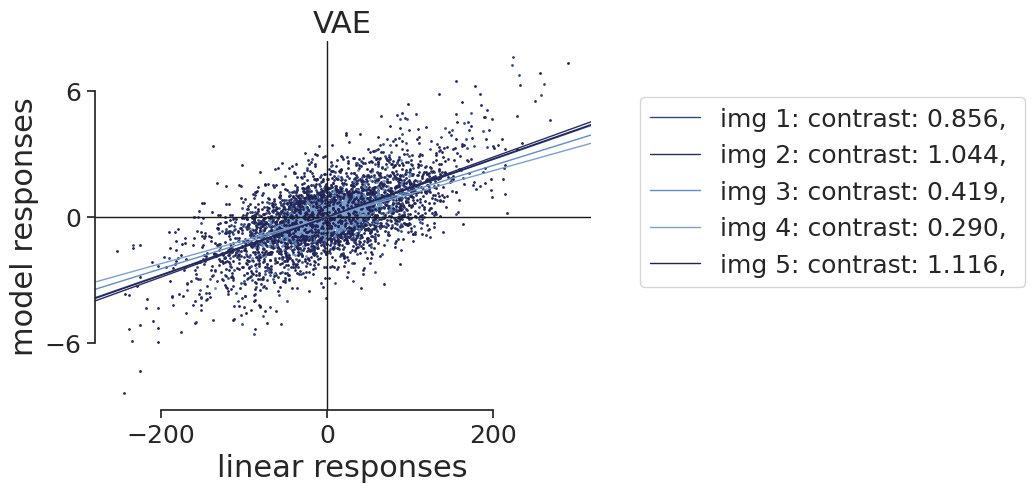

In [47]:
colorPalette = 'Blues'
plot_modelresp_vs_linresp_linfit(test_ims_standardvae,
                                 linear_responses_standardvae,
                                 active_postmns_standardvae,
                                 range(5), 'VAE', colorPalette)

#:  0 100*norm_ind:  1.3768769800662994 contrast:  0.8561818
#:  1 100*norm_ind:  1.295148115605116 contrast:  1.2467247
#:  2 100*norm_ind:  1.4610790647566319 contrast:  0.6078101
#:  3 100*norm_ind:  1.6133017838001251 contrast:  0.40883967
#:  4 100*norm_ind:  1.3858357444405556 contrast:  0.91386706


/tmp/ipykernel_1629327/584611369.py:63: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


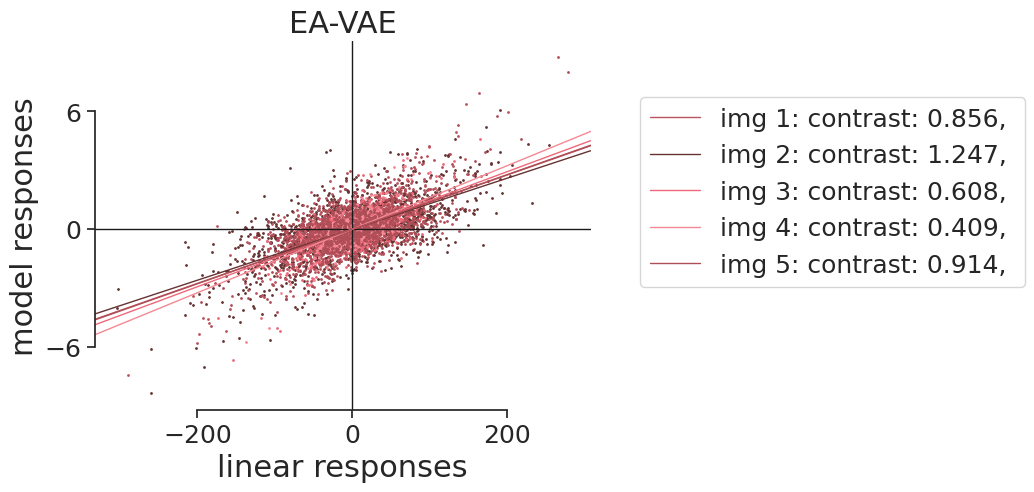

In [48]:
ims_to_show = [0, 7, 8, 21, 23] # range(5), or custom list etc.
colorPalette='Reds'
plot_modelresp_vs_linresp_linfit(test_ims_eavae,
                                 linear_responses_eavae,
                                 active_postmns_eavae,
                                 ims_to_show, 'EA-VAE', colorPalette)


_______
****Plotting panel E & F****
------

**Slope of fit vs response intensity (L2 norm of posterior means)**

/tmp/ipykernel_1629327/972979423.py:282: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


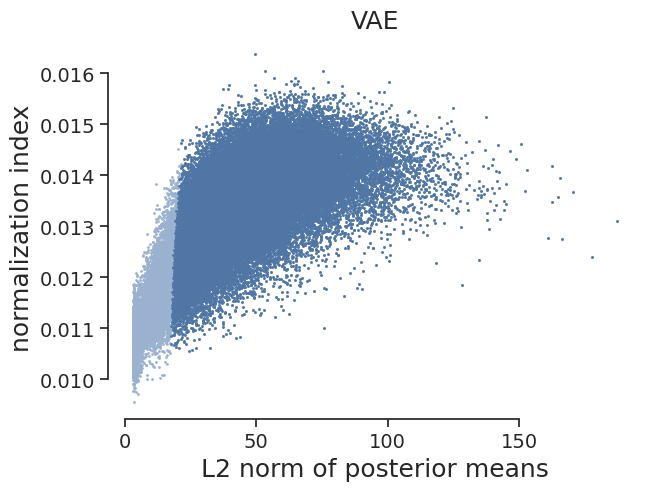

In [49]:
colorsVanilla = [[80/255, 118/255, 166/255],[154/255, 178/255, 208/255]]

plot_slope_vs_posteriornorm(test_ims_standardvae,
                            linear_responses_standardvae,
                            active_postmns_standardvae,
                            'VAE',colorsVanilla)

/tmp/ipykernel_1629327/972979423.py:282: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


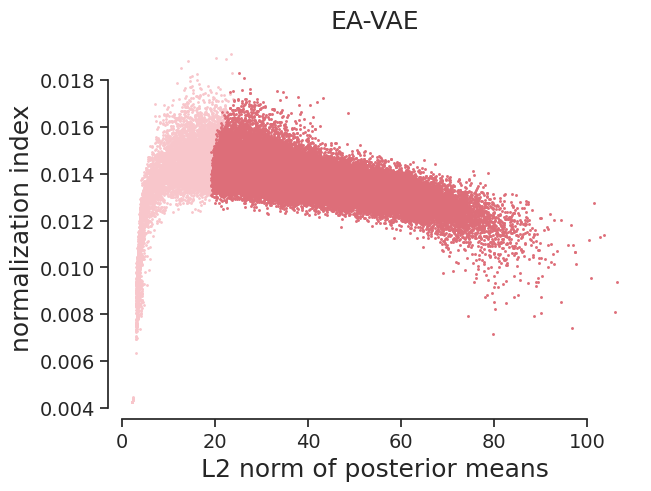

In [50]:
colorsSMVAE = [[221/255, 110/255, 121/255],[248/255, 198/255, 203/255]]

plot_slope_vs_posteriornorm(test_ims_eavae,
                            linear_responses_eavae,
                            active_postmns_eavae,
                            'EA-VAE',colorsSMVAE)


_______
****Plotting panel E & F****
------

**Slope of fit vs image contrast**

/tmp/ipykernel_1629327/972979423.py:235: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


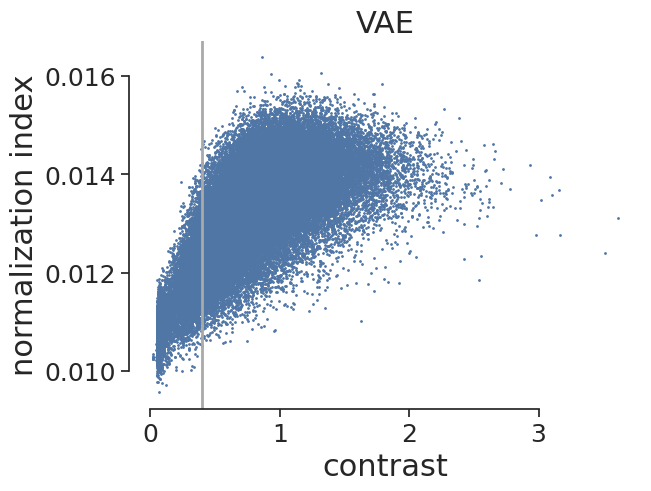

In [51]:
dotColor = [80/255, 118/255, 166/255]
plot_slope_vs_imgcontrast(test_ims_standardvae,
                          linear_responses_standardvae,
                          active_postmns_standardvae,
                          'VAE',dotColor)


/tmp/ipykernel_1629327/972979423.py:235: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


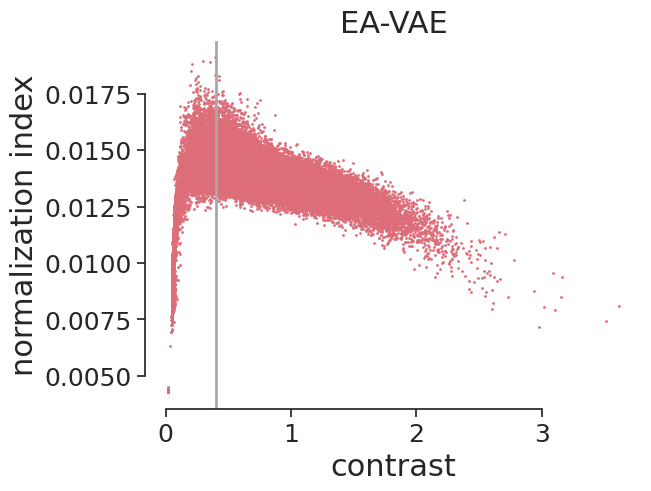

In [52]:
dotColor = [221/255, 110/255, 121/255]

plot_slope_vs_imgcontrast(test_ims_eavae,
                          linear_responses_eavae,
                          active_postmns_eavae,
                          'EA-VAE',dotColor)
